In [1]:
import json
import scipy
import warnings
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from patsy import dmatrices
from scikit_posthocs import posthoc_dunn
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
%matplotlib inline

# ML imports
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_selection import mutual_info_regression, SelectKBest, chi2
from sklearn.model_selection import train_test_split,cross_val_score,learning_curve,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import LinearSVR, SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor, plot_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, max_error

In [2]:
seed = 12132707
np.random.seed(seed)

# Table of contents
1. [Preprocessing](#pp)
2. [Feature Engineering](#fe)
3. [EDA & Hypothesis Testing](#eda)
4. [OLS Regression](#ols)
5. [Ridge](#ridge)
6. [Lasso](#lasso)
7. [Support Vector Regression](#svr)
8. [Random Forest Regression](#rf)
9. [XGBoost](#xgb)
10. [Model Comparison](#comparison)
11. [Generalized Linear Models](#glm)

In [3]:
df = pd.concat([pd.read_csv(
    "./Kaggle-Data-Science-ML-Survey-Analysis/data/processed/ProcessedSurveyDataWithID_%d.csv" % i) 
                       for i in range(2020,2023)])
df = df[df['Country']=='United States of America']
df = df.dropna(subset=['AnnualComp(USD)'])
df.head(3)

,Unnamed: 0,Duration (in seconds),Age,Gender,Country,IsStudent,MOOCPlatforms_Coursera,MOOCPlatforms_edX,MOOCPlatforms_Kaggle Learn Courses,MOOCPlatforms_DataCamp,...,Q35_B_Part_3,Q35_B_Part_4,Q35_B_Part_5,Q35_B_Part_6,Q35_B_Part_7,Q35_B_Part_8,Q35_B_Part_9,Q35_B_Part_10,Q35_B_OTHER,PID
1,49971,289287,30-34,Man,United States of America,No,1,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2_2020
3,49973,507,30-34,Man,United States of America,No,1,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4_2020
11,49981,742,35-39,Man,United States of America,No,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12_2020


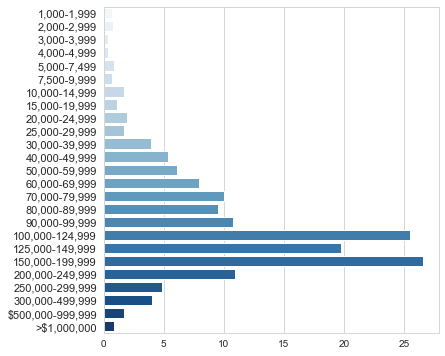

In [5]:
order = ["1,000-1,999", "2,000-2,999", "3,000-3,999", "4,000-4,999", "5,000-7,499", "7,500-9,999", 
         "10,000-14,999", "15,000-19,999", "20,000-24,999", "25,000-29,999", "30,000-39,999", "40,000-49,999", 
         "50,000-59,999", "60,000-69,999", "70,000-79,999", "80,000-89,999", "90,000-99,999", "100,000-124,999", 
         "125,000-149,999", "150,000-199,999", "200,000-249,999", "250,000-299,999", "300,000-499,999", 
         "$500,000-999,999", ">$1,000,000"]

s = df['AnnualComp(USD)'].value_counts()
s = s/len(s)

plt.figure(figsize=(6,6))
sns.barplot(s.values, s.index, palette='Blues', order=order)
plt.yticks(size=11)
plt.show()

# 1. Preprocessing <a name="pp"></a>

## 1.1 Salary: Categorical -> Numeric 

### Problem:
The salaries are reported on a categorical scale, and have unequal bin widths. Exp: 1-2k, 2.5-5k, 125k-150k. These need to be converted to a numerical scale.

### Possible solutions
1. Assume a **uniform distribution** over the lower and upper salary limit. For exp, for salary range 1-2k, sample a salary uniformly between 1-2k.
2. Sample a no. s between 0 and 1 from a **Beta distribution** centered at 0.5. Sampled salary = LL + s (UL - LL).
3. Get the distribution of salaries from a tech salaries dataset. Normalize the densities in a constrained range and sample from the constrained distribution using **Inverse Transform sampling** (for exp, normalize densities bw 125k-150k to integrate to 1, and sample from this distribution).

In [6]:
sal = pd.read_csv("./salaries.csv")
sal[sal['company_location'] == 'US']
sal.head(3)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2022,SE,FT,Data Analyst,177000,USD,177000,US,0,US,M
1,2022,SE,FT,Data Analyst,131000,USD,131000,US,0,US,M
2,2022,SE,FT,Applied Scientist,205000,USD,205000,US,100,US,M


In [7]:
sal['work_year'].value_counts()

2022    1163
2021     224
2020      75
Name: work_year, dtype: int64

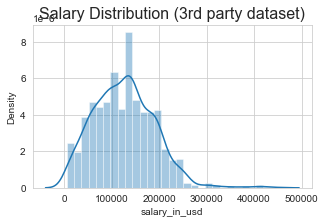

In [8]:
plt.figure(figsize=(5,3))
sns.distplot(sal['salary_in_usd'])
plt.title("Salary Distribution (3rd party dataset)", size=16)
plt.show()

In [9]:
def compute_cdf(salaries): # Empirical CDF
    cdf = np.cumsum(salaries)
    cdf = (cdf - cdf.min())/(cdf.max() - cdf.min()) # Normalize from 0 to 1
    return cdf

In [10]:
# Inverse Transform Sampling
salaries = np.sort(sal['salary_in_usd'])
cdf = compute_cdf(salaries) # Empirical CDF
inverse_cdf = scipy.interpolate.interp1d(cdf, salaries) # Interpolate values of salary for all vals bw 0 & 1
inverse_cdf(0.1) # Inverse transform sampling to sample from the required distribution

array(80000.)

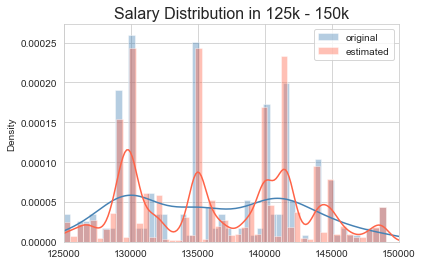

In [11]:
# Suppose we want samples for salary category 125k-150k
sal_1 = salaries[(salaries >= 125000) & (salaries < 150000)]
sal_1 = np.sort(sal_1)
cdf = compute_cdf(sal_1)
inverse_cdf = scipy.interpolate.interp1d(cdf, sal_1)

# Inverse Transform Sampling
u = np.random.random(size=10**5) # Uniform samples

plt.figure(figsize=(6,4))
sns.distplot(sal_1, color='steelblue', label='original', bins=50)
sns.distplot(inverse_cdf(u), color='tomato', label='estimated')
plt.xlim(125000, 150000)
plt.title("Salary Distribution in 125k - 150k", size=16)
plt.legend()
plt.show()

In [12]:
salary_grps = [(1000,1999), (2000,2999), (3000,3999), (4000,4999), (5000,7499), (7500,9999), (10000,14999),
        (15000,19999), (20000,24999), (25000,29999), (30000,39999), (40000,49999), (50000,59999), (60000,69999),
        (70000,79999), (80000,89999), (90000,99999), (100000,124999), (125000,149999), (150000,199999),
        (200000,249999), (250000,299999), (300000,499999), (500000,999999), (1000000,1000000)]

In [13]:
inverse_cdfs = {}
salaries = np.sort(sal['salary_in_usd'])

for ll, ul in salary_grps:
    sals = salaries[(salaries >= ll) & (salaries < ul)]
    if len(sals) < 20:
        #print(ll, len(sals))
        continue
    sals = np.insert(sals, 0, ll)
    sals = np.insert(sals, len(sals), ul)
    sals = np.sort(sals)
    cdf = compute_cdf(sals)
    inverse_cdf = scipy.interpolate.interp1d(cdf, sals)
    inverse_cdfs[ll] = inverse_cdf

In [14]:
def sample_salary(sal_categ, salary_grps, inverse_cdfs):
    if sal_categ == "> $500,000":
        return np.random.uniform(500000, 1000000)
    
    elif sal_categ == ">$1,000,000":
        return np.random.uniform(1000000, 1500000)
    
    else:
        sal_categ = sal_categ.replace(',', '').replace('$', '')
        sal_categ = sal_categ.strip()

        lims = sal_categ.split('-')
        ll = int(lims[0])
        ul = int(lims[1])

        if(ll in inverse_cdfs):
            u = np.random.uniform(0,1) # Uniform sample bw 0, 1
            return inverse_cdfs[ll](u)

            return np.random.uniform(ll, ul) # If insufficient no. of samples, assume uniform distribution

In [15]:
df['salary'] = df['AnnualComp(USD)'].apply(lambda sal: sample_salary(sal, salary_grps, inverse_cdfs))

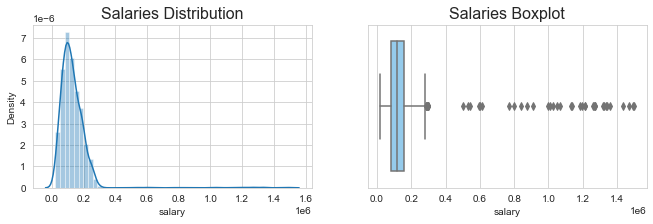

In [16]:
fig, axs = plt.subplots(1,2, figsize=(11,3))
sns.distplot(df['salary'], ax=axs[0])
sns.boxplot(df['salary'], ax=axs[1], color='lightskyblue')
axs[0].set_title("Salaries Distribution", size=16)
axs[1].set_title("Salaries Boxplot", size=16)
plt.show()

In [17]:
# Note that Salaries have outliers, which may be hard to predict

# Feature Engineering <a name="fe"></a>

In [18]:
feature_df = pd.read_csv(
    "./Kaggle-Data-Science-ML-Survey-Analysis/data/processed/DS-MLE-DA-DE-RS-FeatureEngineered.csv")
feature_df.head(3)

,PID,CurrentTitle,Age,NumCoursePlatforms,EduOrdinal,ProgExpOrdinal,NumProgLanguages,MLExpOrdinal,NumMLFrameworks,NumTransferLearning,...,UsedGraphModels,UsedGCP,UsedAWS,UsedAzure,UsedRelationalDBs,UsedNonRelationalDBs,UsedPowerBI,UsedTableau,UsedGPU,UsedE2EPipelineAutomation
0,2_2020,Data Engineer,30-34,3,3.0,5.0,3.0,2.0,4.0,0.0,...,0.0,1,1,1,1,0,1,1,1,0
1,4_2020,Data Scientist,30-34,4,3.0,5.0,3.0,4.0,4.0,0.0,...,0.0,0,1,0,1,0,0,1,0,0
2,6_2020,Data Analyst,30-34,0,2.0,1.0,2.0,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0


In [19]:
df.shape

(4763, 567)

In [20]:
df_merged = df[["PID", "SurveyYear", "Gender", "CompanySize", "DSTeamSize", "Industry",
                "salary"]].merge(feature_df, on="PID")
df_merged = df_merged.dropna(subset=["salary"])
df_merged.head(3)

,PID,SurveyYear,Gender,CompanySize,DSTeamSize,Industry,salary,CurrentTitle,Age,NumCoursePlatforms,...,UsedGraphModels,UsedGCP,UsedAWS,UsedAzure,UsedRelationalDBs,UsedNonRelationalDBs,UsedPowerBI,UsedTableau,UsedGPU,UsedE2EPipelineAutomation
0,2_2020,2020,Man,"10,000 or more employees",20+,NaN,101228.534003,Data Engineer,30-34,3,...,0.0,1,1,1,1,0,1,1,1,0
1,4_2020,2020,Man,250-999 employees,5-9,NaN,144000.000000,Data Scientist,30-34,4,...,0.0,0,1,0,1,0,0,1,0,0
2,12_2020,2020,Man,0-49 employees,1-2,NaN,34750.771364,Research Scientist,35-39,0,...,0.0,0,0,0,0,0,0,0,0,0


In [21]:
# Company size
categs = ['0-49 employees', '50-249 employees', '250-999 employees',
          '1000-9,999 employees', '10,000 or more employees']
enc_companysize = OrdinalEncoder(categories=[categs])
df_merged["CompanySize"] = enc_companysize.fit_transform(df_merged["CompanySize"].to_numpy().reshape(-1,1))

# DS Team size
categs = ['0', '1-2', '3-4', '5-9', '10-14', '15-19', '20+']
enc_dsteamsize = OrdinalEncoder(categories=[categs])
df_merged["DSTeamSize"] = enc_dsteamsize.fit_transform(df_merged["DSTeamSize"].to_numpy().reshape(-1,1))

# Response Year
categs = [2020, 2021, 2022]
enc_yr = OrdinalEncoder(categories=[categs])
df_merged["SurveyYear"] = enc_yr.fit_transform(df_merged["SurveyYear"].to_numpy().reshape(-1,1))

In [22]:
CATEGORICAL_FEATURES = ["CurrentTitle", "Industry"]

BINARY_FEATURES = ["CompletedUniDegree", "UsedPython", "UsedR", "UsedSQL", "UsedJupyter", "UsedPyViz", "UsedRViz",
                   "UsedJSViz", "UsedSKlearn", "UsedTFKeras", "UsedPyTorch", "UsedHF", "UsedFastAI", 
                   "UsedLinearModels","UsedTreeModels","UsedGBModels","UsedBayesianModels",
                   "UsedEvolutionaryModels","UsedNNModels","UsedCNNModels","UsedGANModels",
                   "UsedTransformerModels","UsedAEModels","UsedRNNModels","UsedGraphModels", "UsedGCP", 
                   "UsedAWS", "UsedAzure", "UsedRelationalDBs","UsedNonRelationalDBs", "UsedPowerBI",
                   "UsedTableau", "UsedGPU", "UsedE2EPipelineAutomation", 
                  ]

NUMERICAL_FEATURES = ["Age", "SurveyYear", "CompanySize", "DSTeamSize",
                    "NumCoursePlatforms", "EduOrdinal", "ProgExpOrdinal", "NumProgLanguages", "MLExpOrdinal", 
                      "NumMLFrameworks", "NumTransferLearning", "NumCloudProvidersUsed", "NumCloudComputeUsed", 
                      "NumCloudStorageUsed", "NumBIToolsUsed", "NumMLaaSToolsUsed", "NumAutoMLUsed", 
                      "NumMLDeploymentToolsUsed", "NumMLMonitoringToolUsed", "NumHardwareUsed", 
                      "TPUUsageOrdinal", "NumDSContentMediaConsumed", "NumStepsOfPipelineAutomated",
                     ]

## Feature Importance (Numeric)

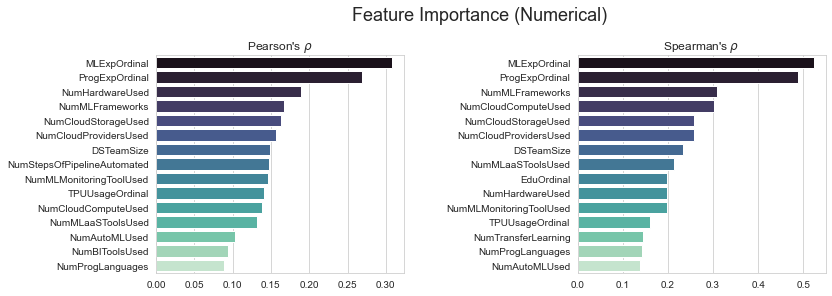

In [23]:
pearson_imp = df_merged[NUMERICAL_FEATURES + ["salary"]].corr(method='pearson')['salary']
pearson_imp = pearson_imp.sort_values(ascending=False)[1:]
spearman_imp = df_merged[NUMERICAL_FEATURES + ["salary"]].corr(method='spearman')['salary']
spearman_imp = spearman_imp.sort_values(ascending=False)[1:]

fig, axs = plt.subplots(1,2, figsize=(12,4), gridspec_kw={"wspace":0.7})
sns.barplot(y=pearson_imp.index[:15], x=pearson_imp.values[:15], palette='mako', ax=axs[0])
sns.barplot(y=spearman_imp.index[:15], x=spearman_imp.values[:15], palette='mako', ax=axs[1])
plt.suptitle('Feature Importance (Numerical)', size=18, y=1.05)
axs[0].set_title(r"Pearson's $\rho$")
axs[1].set_title(r"Spearman's $\rho$")
plt.show()

In [24]:
# Common Top 10
spearman_imp[list(set(pearson_imp.index[:10]).intersection(
                                                set(spearman_imp.index[:10])))].sort_values(ascending=False)

MLExpOrdinal             0.522748
ProgExpOrdinal           0.488266
NumMLFrameworks          0.309560
NumCloudStorageUsed      0.258188
NumCloudProvidersUsed    0.256864
DSTeamSize               0.232504
NumHardwareUsed          0.198536
Name: salary, dtype: float64

In [25]:
# Least Important features
spearman_imp[-5:]

NumStepsOfPipelineAutomated    0.123180
NumBIToolsUsed                 0.083155
SurveyYear                     0.065767
NumDSContentMediaConsumed      0.054908
NumCoursePlatforms             0.025691
Name: salary, dtype: float64

# Exploratory Data Analysis <a name="eda"></a>

## ML Experience

Kruskal Wallis:  KruskalResult(statistic=661.342380000885, pvalue=1.4973065430038263e-137)


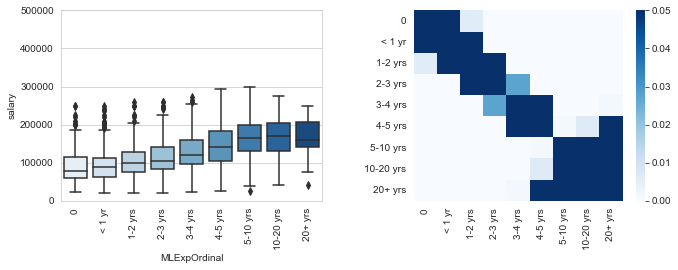

In [26]:
fig, axs = plt.subplots(1,2, figsize=(11,3.5), gridspec_kw={"wspace":0.35})
sns.boxplot(x='MLExpOrdinal', y='salary', data=df_merged, palette='Blues', ax=axs[0], order=list(range(9)))
axs[0].set_ylim(0, 500000)

labels = ['0', '< 1 yr', '1-2 yrs', '2-3 yrs', '3-4 yrs', '4-5 yrs', '5-10 yrs', '10-20 yrs', '20+ yrs']
data = [df_merged[df_merged["MLExpOrdinal"]==val]['salary'].dropna().tolist() for val in list(range(9))]
print("Kruskal Wallis: ", stats.kruskal(*data))
sns.heatmap(posthoc_dunn(data, p_adjust='bonferroni'), vmax=0.05, cmap='Blues', ax=axs[1])
axs[0].set_xticks(list(range(9)), labels, rotation=90)
axs[1].set_xticks(np.arange(0.5, 9.5, 1), labels, rotation=90)
axs[1].set_yticks(np.arange(0.5, 9.5, 1), labels, rotation=0)
plt.show()

* Difference between successive years is not significant.
* At senior positions, salary is indisntinguishable: Exp at 20+yrs not significantly different from 4-20 yrs.
* For juniors, outliers towards upper extreme, for seniors, outliers towards lower extreme.

## Programming Experience

Kruskal Wallis:  KruskalResult(statistic=580.7630022085455, pvalue=3.3767954798889713e-121)


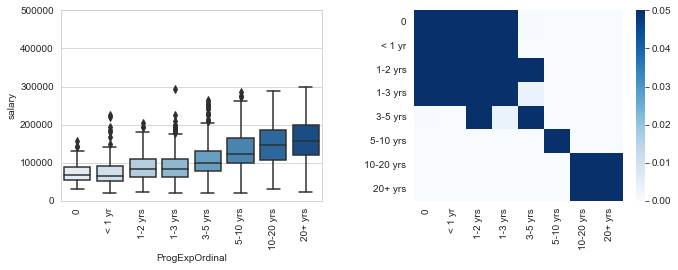

In [27]:
fig, axs = plt.subplots(1,2, figsize=(11,3.5), gridspec_kw={"wspace":0.35})
sns.boxplot(x='ProgExpOrdinal', y='salary', data=df_merged, palette='Blues', ax=axs[0], order=list(range(8)))
axs[0].set_ylim(0, 500000)

labels = ['0', '< 1 yr', '1-2 yrs', '1-3 yrs', '3-5 yrs', '5-10 yrs', '10-20 yrs', '20+ yrs']

data = [df_merged[df_merged["ProgExpOrdinal"]==val]['salary'].dropna().tolist() for val in list(range(8))]
print("Kruskal Wallis: ", stats.kruskal(*data))
sns.heatmap(posthoc_dunn(data, p_adjust='bonferroni'), vmax=0.05, cmap='Blues', ax=axs[1])
axs[0].set_xticks(list(range(8)), labels, rotation=90)
axs[1].set_xticks(np.arange(0.5, 8.5, 1), labels, rotation=90)
axs[1].set_yticks(np.arange(0.5, 8.5, 1), labels, rotation=0)
plt.show()

* No difference for junior programmers (0-3 yrs of experience)

## Gender

In [28]:
df_merged["Gender"].value_counts()

Man                        1820
Woman                       480
Prefer not to say            39
Nonbinary                    20
Prefer to self-describe       4
Name: Gender, dtype: int64

In [29]:
# Gender - One Hot Encoding (Man/Woman/Other)
genders = ["Man", "Woman"]
df_merged.loc[~df_merged["Gender"].isin(genders), "Gender"] = "Other"
ohe_gender = OneHotEncoder(drop=['Other'])

gender_ohe_df = ohe_gender.fit_transform(np.array(df_merged["Gender"]).reshape(-1,1)).toarray()
gender_ohe_df = pd.DataFrame(gender_ohe_df, columns = genders) # OHE For linear models

Kruskal Wallis:  KruskalResult(statistic=43.02953702034373, pvalue=4.5316332700027527e-10)


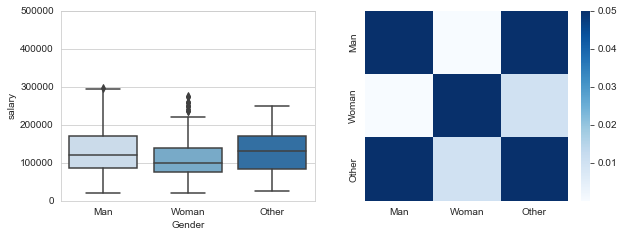

In [30]:
genders = ["Man", "Woman", "Other"]

fig, axs = plt.subplots(1,2, figsize=(10,3.5))
sns.boxplot(x='Gender', y='salary', data=df_merged, palette='Blues', ax=axs[0], order=genders)
axs[0].set_ylim(0, 500000)

data = [df_merged[df_merged["Gender"]==gender]['salary'].dropna().tolist() for gender in genders]
print("Kruskal Wallis: ", stats.kruskal(*data))
sns.heatmap(posthoc_dunn(data, p_adjust='bonferroni'), vmax=0.05, cmap='Blues', ax=axs[1])
axs[1].set_xticks(np.arange(0.5, 3.5, 1), genders)
axs[1].set_yticks(np.arange(0.5, 3.5, 1), genders)
plt.show()

* Unfortunate to see that Men & Women salaries are significantly different.

## Age

In [31]:
# Ordinal Encoding of Age
enc_age = OrdinalEncoder(categories=[np.sort(df_merged["Age"].unique())])
df_merged["Age_categ"] = enc_age.fit_transform(df_merged["Age"].to_numpy().reshape(-1,1))
df_merged = df_merged.drop("Age", axis=1)

Kruskal Wallis:  KruskalResult(statistic=190.96217994214445, pvalue=1.2329084082544773e-35)


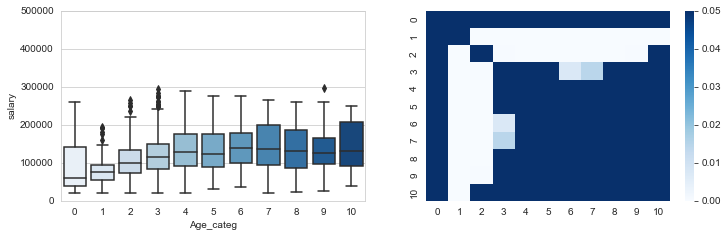

In [32]:
fig, axs = plt.subplots(1,2, figsize=(12,3.5))
sns.boxplot(x='Age_categ', y='salary', data=df_merged, palette='Blues', ax=axs[0], order=list(range(11)))
axs[0].set_ylim(0, 500000)

data = [df_merged[df_merged["Age_categ"]==age_grp]['salary'].dropna().tolist() for age_grp in list(range(11))]
print("Kruskal Wallis: ", stats.kruskal(*data))
sns.heatmap(posthoc_dunn(data, p_adjust='bonferroni'), vmax=0.05, cmap='Blues', ax=axs[1])
axs[1].set_xticks(np.arange(0.5, 11.5, 1), list(range(11)))
axs[1].set_yticks(np.arange(0.5, 11.5, 1), list(range(11)))
plt.show()

* Age does not really matter after 2 yrs in the industry!

## Job Title

Kruskal Wallis:  KruskalResult(statistic=467.99774900394294, pvalue=5.580149243667257e-100)


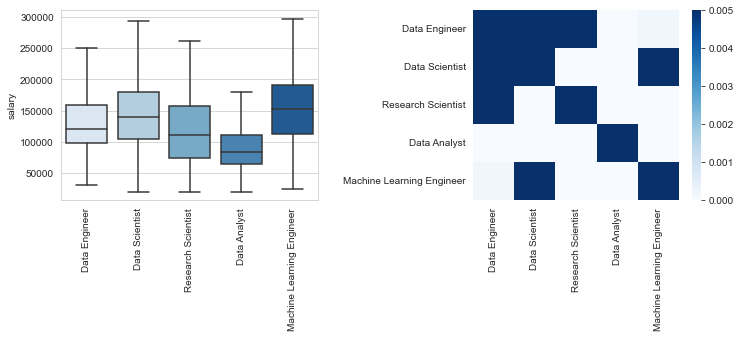

In [33]:
titles = df_merged["CurrentTitle"].unique()

fig, axs = plt.subplots(1,2, figsize=(12,3.5), gridspec_kw={"wspace":0.6})
sns.boxplot(x='CurrentTitle', y='salary', data=df_merged, palette='Blues', ax=axs[0], showfliers=False)
# axs[0].set_ylim(0, 500000)
axs[0].set_xticks(np.arange(0, 5, 1), titles, rotation=90)
axs[0].set_xlabel("")

data = [df_merged[df_merged["CurrentTitle"]==title]['salary'].dropna().tolist() for title in titles]
print("Kruskal Wallis: ", stats.kruskal(*data))
sns.heatmap(posthoc_dunn(data, p_adjust='bonferroni'), vmax=0.005, cmap='Blues', ax=axs[1])
axs[1].set_xticks(np.arange(0.5, 5.5, 1), titles, rotation=90)
axs[1].set_yticks(np.arange(0.5, 5.5, 1), titles, rotation=0)
plt.show()

* MLEs have the highest median salary (over 150k), significantly different from all job titles, except Data Scientists.
* Data Analysts have the least median salary (<100k), significantly different from all other job categories.

## Binary features (Mutual Information)

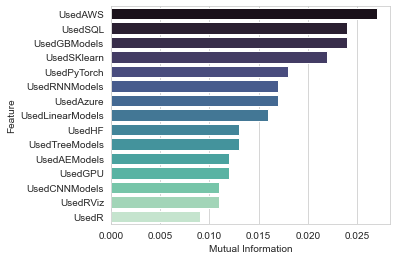

In [34]:
mi_scores = mutual_info_regression(df_merged[BINARY_FEATURES], df_merged["salary"], random_state=seed)
mi_df = []

for i in np.argsort(mi_scores)[::-1]:
    mi_df.append([BINARY_FEATURES[i], np.round(mi_scores[i],3)])
    
mi_df = pd.DataFrame(mi_df, columns=['Feature', 'Mutual Information'])

plt.figure(figsize=(5,4))
sns.barplot(y=mi_df["Feature"].iloc[:15], x=mi_df["Mutual Information"].iloc[:15], palette='mako')
plt.show()

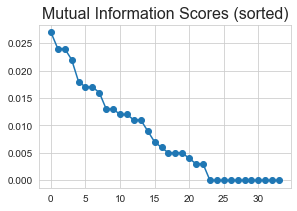

In [35]:
plt.figure(figsize=(4.5,3))
plt.plot(mi_df["Mutual Information"], marker='o')
plt.title("Mutual Information Scores (sorted)", size=16)
plt.show()

UsedAWS


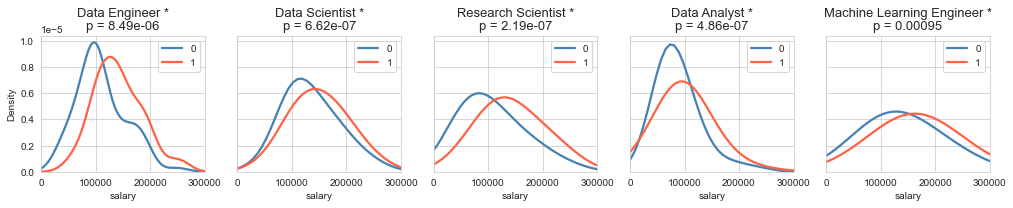

UsedSQL


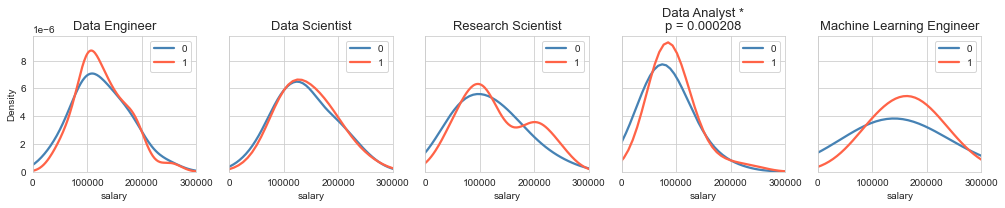

UsedGBModels


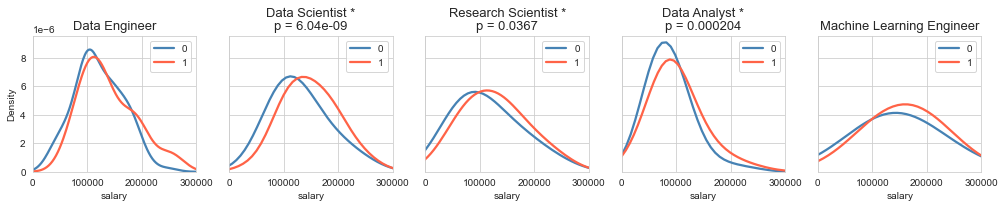

UsedSKlearn


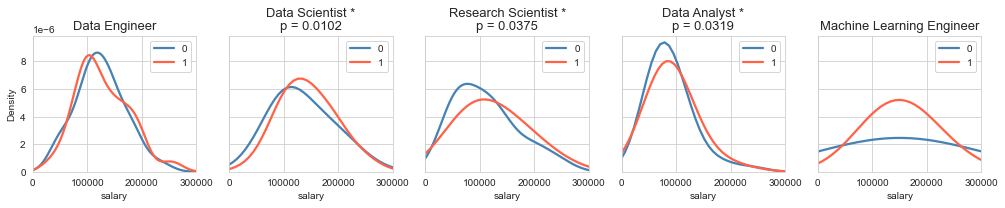

UsedPyTorch


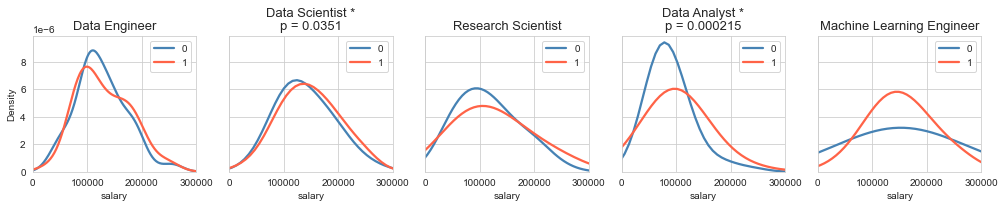

UsedRNNModels


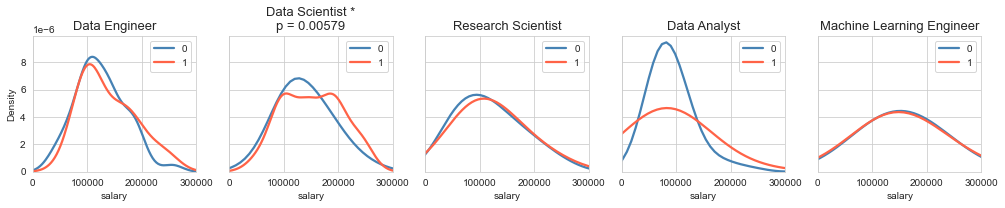

UsedAzure


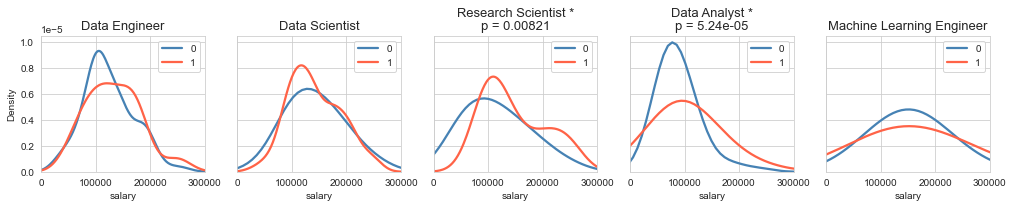

UsedLinearModels


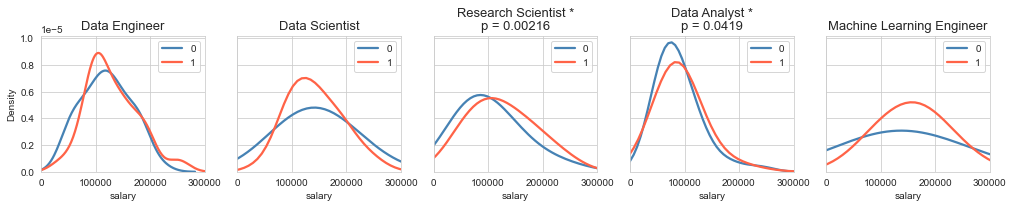

UsedHF


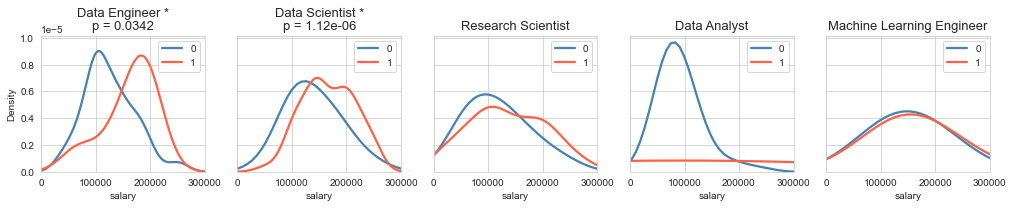

UsedTreeModels


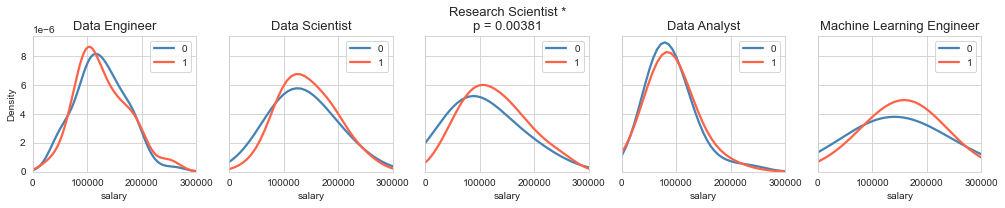

UsedAEModels


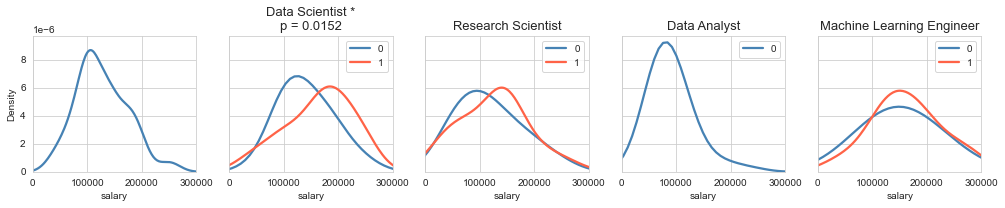

UsedGPU


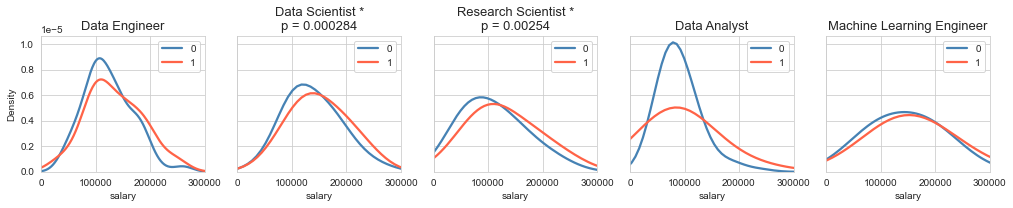

UsedCNNModels


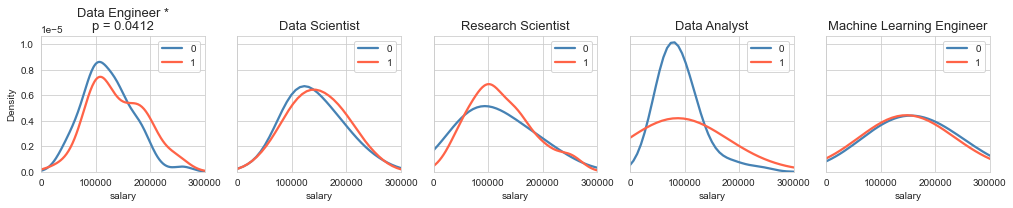

UsedRViz


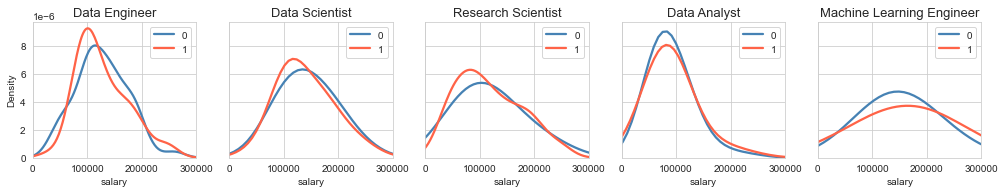

UsedR


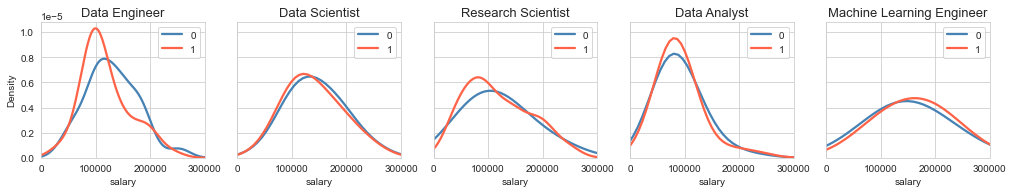

UsedPyViz


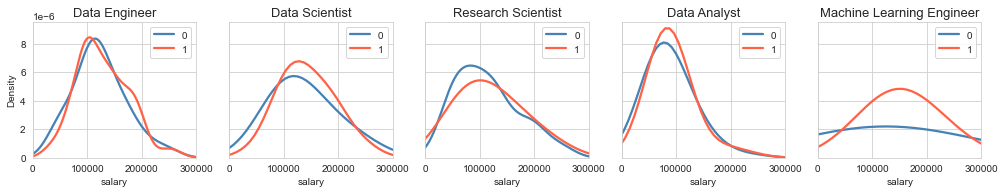

UsedFastAI


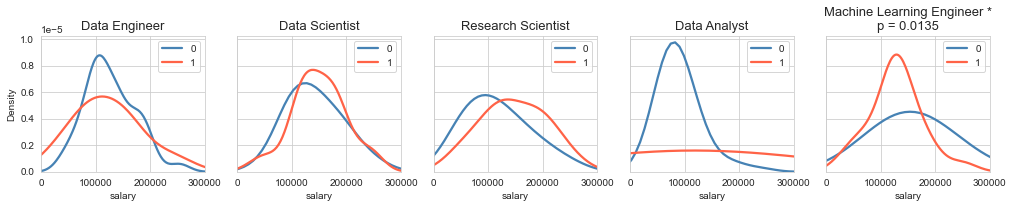

UsedGANModels


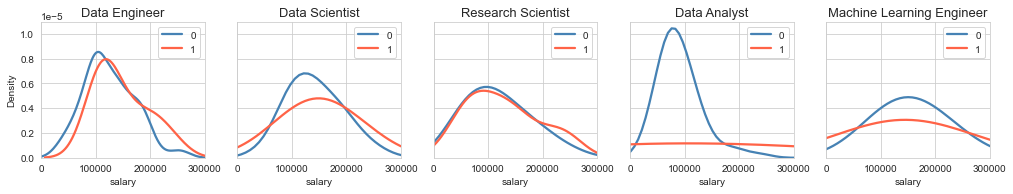

CompletedUniDegree


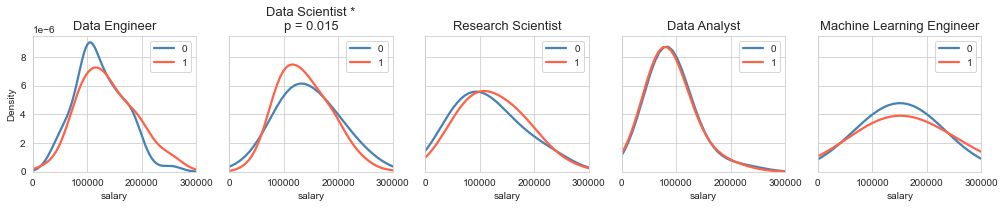

UsedE2EPipelineAutomation


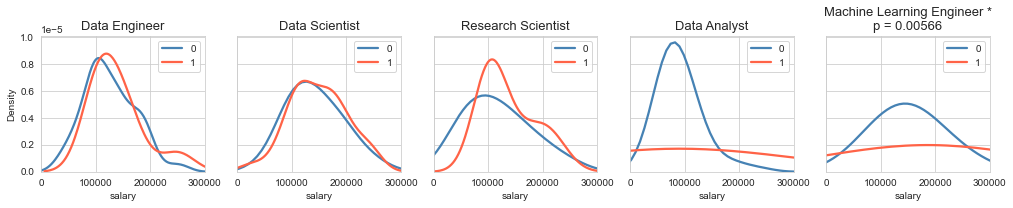

UsedPowerBI


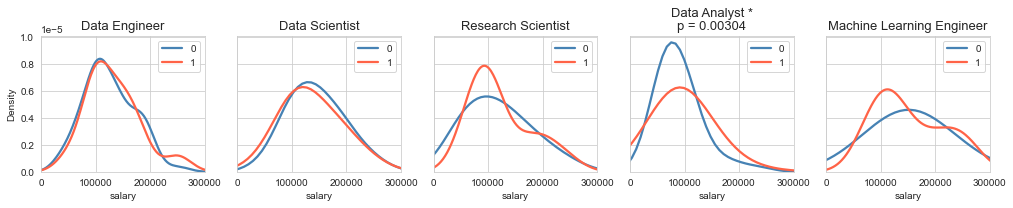

UsedJupyter


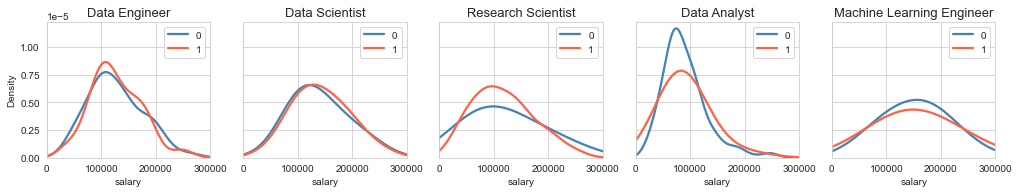

UsedJSViz


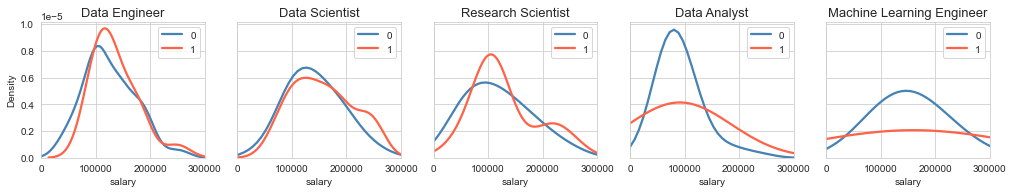

UsedTableau


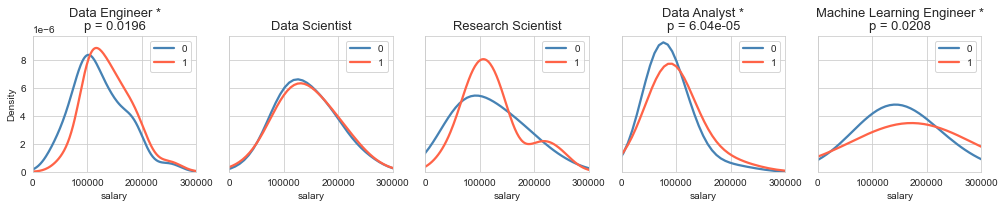

UsedEvolutionaryModels


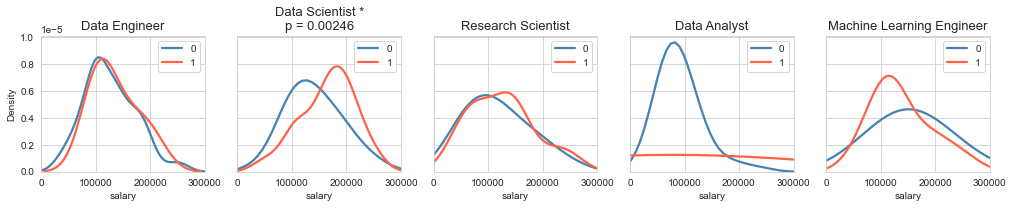

UsedNNModels


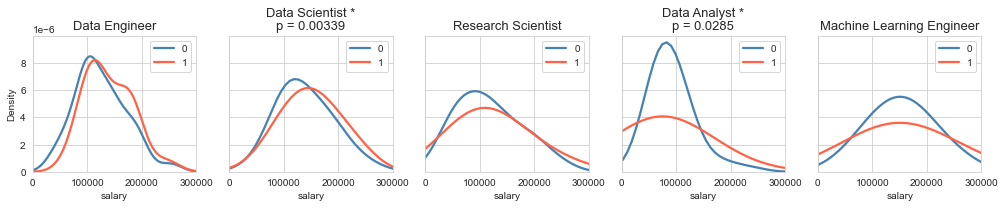

UsedTransformerModels


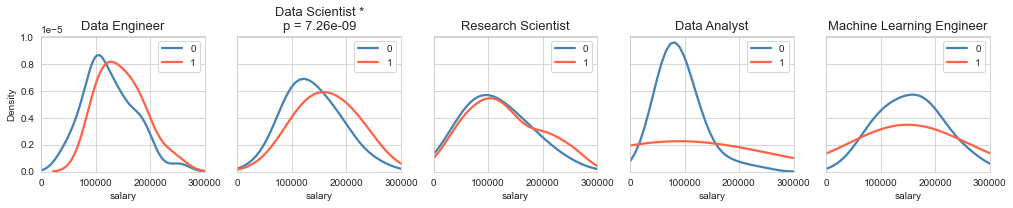

UsedGraphModels


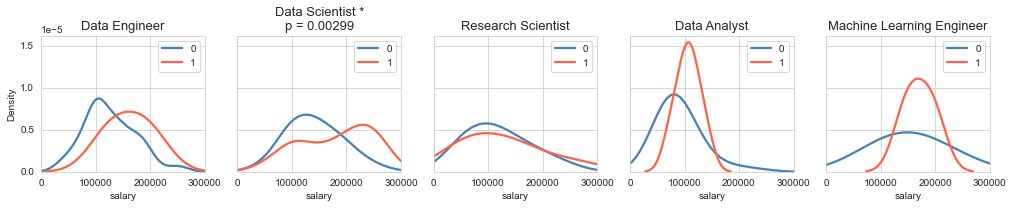

UsedTFKeras


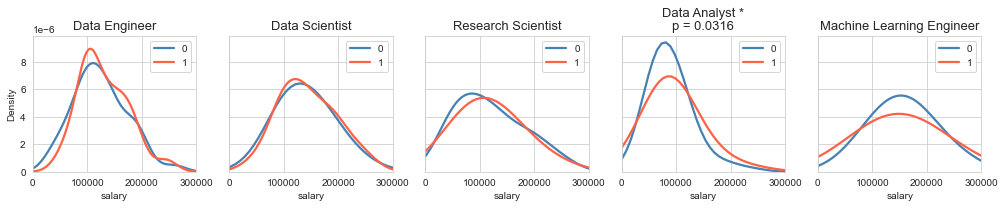

UsedGCP


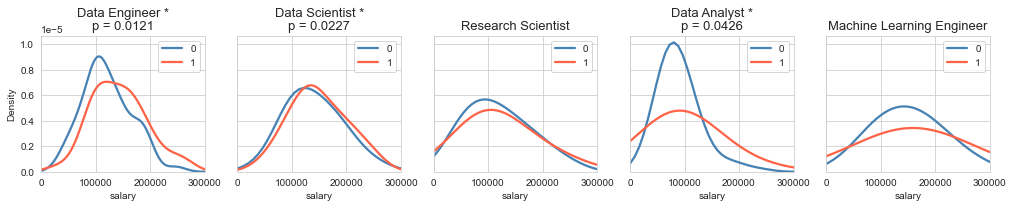

UsedRelationalDBs


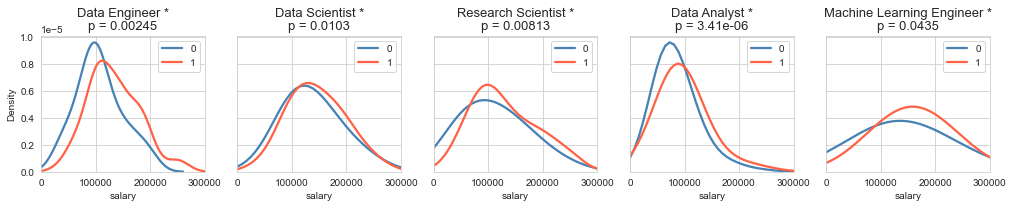

UsedNonRelationalDBs


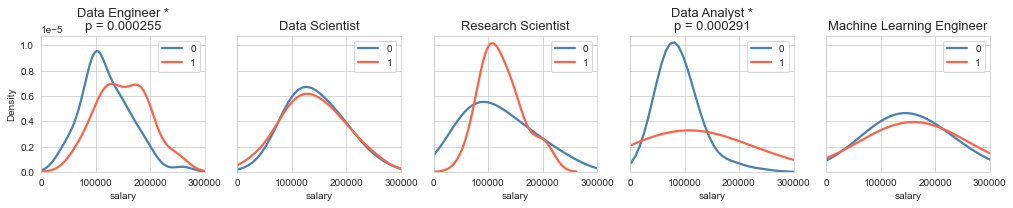

UsedPython


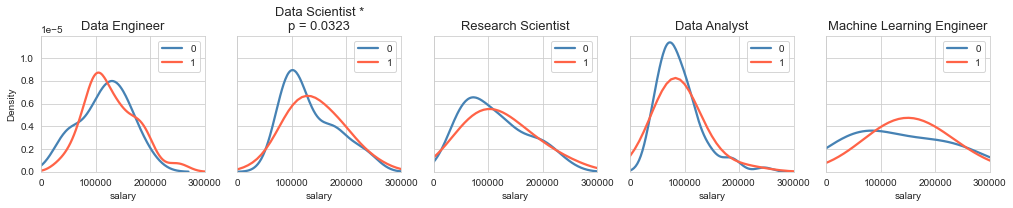

UsedBayesianModels


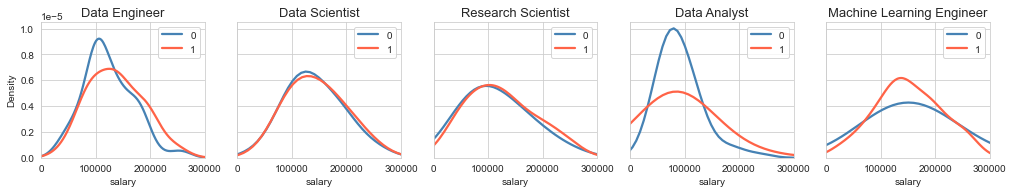

In [36]:
jobtitles = df_merged['CurrentTitle'].unique()
colors = ['steelblue', 'tomato']

for feat in mi_df["Feature"].values: # Top 10 features
    print(feat)
    
    fig, axs = plt.subplots(1,5, figsize=(17,2.5), sharex=True, sharey=True)

    for idx in range(len(jobtitles)):
        title = jobtitles[idx]
        subdf = df_merged[df_merged["CurrentTitle"] == title]
        data = []
        for categ in range(2):
            subgroup = subdf[subdf[feat]==categ]['salary']
            data.append(subgroup)
            sns.distplot(subgroup, ax=axs[idx], color=colors[categ],
                         label=categ, hist=False, kde_kws=dict(linewidth=2.25))
        
        try:
            mw_res = stats.mannwhitneyu(*data) # Mann-Whitney U-test
            if mw_res.pvalue < 0.05:
                axs[idx].set_title(title + " *\np = " + str( "%.3g" % mw_res.pvalue), size=13)
            else:
                axs[idx].set_title(title, size=13)
            axs[idx].set_xlim(0, 3e5)
            axs[idx].legend()
        except:
            continue

    plt.show()

* Some features such as UsedAWS significantly different for all job titles, but the difference is more pronounced for Data Engineer, Research Scientists.
* Other features are important for specific job titles, exp Data scientists who know ML are paid more: Transformer models, GB, Sklearn.
* Completed University degree does not seem to matter, except for Data Scientists!

In [37]:
# One Hot Encoding of Job Title (5 categories: Data Scientist, Analyst, Engineer, MLE, Research Scientist)
ohe_job = OneHotEncoder(drop='first')
title_ohe_df = ohe_job.fit_transform(np.array(df_merged["CurrentTitle"]).reshape(-1,1)).toarray()
job_titles = ohe_job.categories_[0][1:]
title_ohe_df = pd.DataFrame(title_ohe_df, columns = job_titles)
title_ohe_df.head(3) # OHE For linear models

,Data Engineer,Data Scientist,Machine Learning Engineer,Research Scientist
0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0


## Industry related features

Kruskal Wallis:  KruskalResult(statistic=205.47945791690802, pvalue=2.26003857858395e-34)


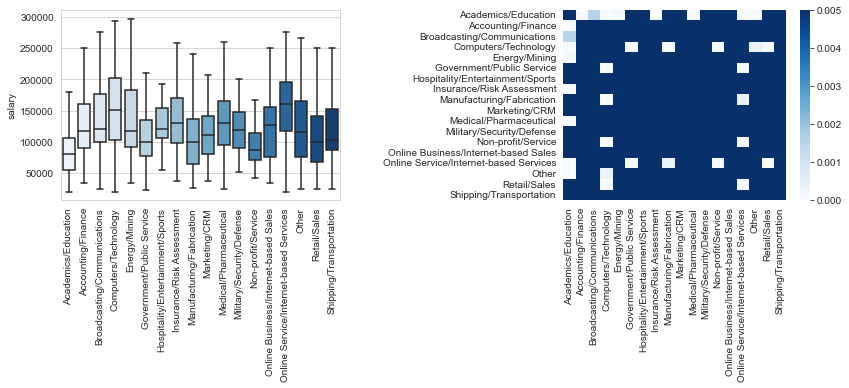

In [38]:
industries = np.sort(df_merged["Industry"].dropna().unique())

fig, axs = plt.subplots(1,2, figsize=(14,3.5), gridspec_kw={"wspace":0.8})
sns.boxplot(x='Industry', y='salary', data=df_merged, palette='Blues', ax=axs[0], showfliers=False,
           order=industries)
# axs[0].set_ylim(0, 500000)
axs[0].set_xticks(np.arange(0, 18, 1), industries, rotation=90)
axs[0].set_xlabel("")

data = [df_merged[df_merged["Industry"]==title]['salary'].dropna().tolist() for title in industries]
print("Kruskal Wallis: ", stats.kruskal(*data))
sns.heatmap(posthoc_dunn(data, p_adjust='bonferroni'), vmax=0.005, cmap='Blues', ax=axs[1])
axs[1].set_xticks(np.arange(0.5, 18.5, 1), industries, rotation=90)
axs[1].set_yticks(np.arange(0.5, 18.5, 1), industries, rotation=0)
plt.show()

In [39]:
cnts = df['Industry'].value_counts()
cnts = cnts.reset_index().rename(columns={"Industry":"count", "index":"Industry"})
meds = df.groupby("Industry")["salary"].median().sort_values(ascending=False).reset_index()
meds.merge(cnts, on="Industry")

,Industry,salary,count
0,Online Service/Internet-based Services,160039.380268,136
1,Computers/Technology,141413.559802,713
2,Insurance/Risk Assessment,129300.000000,124
3,Medical/Pharmaceutical,129300.000000,307
4,Online Business/Internet-based Sales,125000.000000,20
5,Energy/Mining,123140.375643,98
6,Accounting/Finance,121228.384794,310
7,Broadcasting/Communications,117000.000000,64
8,Marketing/CRM,116212.381219,75
9,Other,111285.000000,275


In [40]:
p25 = np.percentile(meds['salary'], 25)
p50 = np.percentile(meds['salary'], 50)
p75 = np.percentile(meds['salary'], 75)
p25, p50, p75

(100000.0, 113748.69060929705, 124535.09391077804)

In [41]:
industry_map = {}

for _, row in meds.iterrows():
    if row["salary"] > p75:
        industry_map[row["Industry"]] = 4
    elif row["salary"] > p50 and row["salary"] <= p75:
        industry_map[row["Industry"]] = 3
    elif row["salary"] > p25 and row["salary"] <= p50:
        industry_map[row["Industry"]] = 2
    else:
        industry_map[row["Industry"]] = 1

df_merged["IndustryPayScale"] = df_merged["Industry"].map(industry_map)
df_merged['IndustryPayScale'] = df_merged['IndustryPayScale'].fillna(0) # 793 null values

In [42]:
stats.pearsonr(df_merged['IndustryPayScale'], df_merged['salary']) # Pearson Correlation

(0.13545036238778013, 3.808513861955721e-11)

In [43]:
stats.spearmanr(df_merged['IndustryPayScale'], df_merged['salary']) # Spearman Correlation

SpearmanrResult(correlation=0.1635194666794576, pvalue=1.259627662131414e-15)

Kruskal Wallis:  KruskalResult(statistic=171.59820336332285, pvalue=4.7472140892022644e-36)


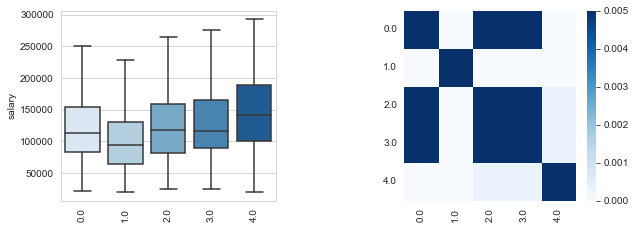

In [44]:
industries = np.sort(df_merged["IndustryPayScale"].dropna().unique())

fig, axs = plt.subplots(1,2, figsize=(10,3.5), gridspec_kw={"wspace":0.6})
sns.boxplot(x='IndustryPayScale', y='salary', data=df_merged, palette='Blues', ax=axs[0], showfliers=False,
           order=industries)
# axs[0].set_ylim(0, 500000)
axs[0].set_xticks(np.arange(0, 5, 1), industries, rotation=90)
axs[0].set_xlabel("")

data = [df_merged[df_merged["IndustryPayScale"]==title]['salary'].dropna().tolist() for title in industries]
print("Kruskal Wallis: ", stats.kruskal(*data))
sns.heatmap(posthoc_dunn(data, p_adjust='bonferroni'), vmax=0.005, cmap='Blues', ax=axs[1])
axs[1].set_xticks(np.arange(0.5, 5.5, 1), industries, rotation=90)
axs[1].set_yticks(np.arange(0.5, 5.5, 1), industries, rotation=0)
plt.show()

### Combining Features

In [45]:
ENCODED_CATEG_FEATURES = ["Gender", "CurrentTitle", "Industry"]

num_feats = spearman_imp.iloc[:10].index.tolist() + ["IndustryPayScale"]
categ_feats = mi_df["Feature"].iloc[:8].values.tolist()
ohe_feats = gender_ohe_df.columns.tolist() + title_ohe_df.columns.tolist()
final_feats = num_feats + categ_feats + ohe_feats
final_feats

['MLExpOrdinal',
 'ProgExpOrdinal',
 'NumMLFrameworks',
 'NumCloudComputeUsed',
 'NumCloudStorageUsed',
 'NumCloudProvidersUsed',
 'DSTeamSize',
 'NumMLaaSToolsUsed',
 'EduOrdinal',
 'NumHardwareUsed',
 'IndustryPayScale',
 'UsedAWS',
 'UsedSQL',
 'UsedGBModels',
 'UsedSKlearn',
 'UsedPyTorch',
 'UsedRNNModels',
 'UsedAzure',
 'UsedLinearModels',
 'Man',
 'Woman',
 'Data Engineer',
 'Data Scientist',
 'Machine Learning Engineer',
 'Research Scientist']

In [46]:
# Merging encoded features with the dataset
df_merged = pd.concat([df_merged.reset_index(drop=True), gender_ohe_df.reset_index(drop=True)], axis=1)
df_merged = pd.concat([df_merged.reset_index(drop=True), title_ohe_df.reset_index(drop=True)], axis=1)
df_merged.head()

,PID,SurveyYear,Gender,CompanySize,DSTeamSize,Industry,salary,CurrentTitle,NumCoursePlatforms,EduOrdinal,...,UsedGPU,UsedE2EPipelineAutomation,Age_categ,IndustryPayScale,Man,Woman,Data Engineer,Data Scientist,Machine Learning Engineer,Research Scientist
0,2_2020,0.0,Man,4.0,6.0,NaN,101228.534003,Data Engineer,3,3.0,...,1,0,3.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,4_2020,0.0,Man,2.0,3.0,NaN,144000.000000,Data Scientist,4,3.0,...,0,0,3.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,12_2020,0.0,Man,0.0,1.0,NaN,34750.771364,Research Scientist,0,4.0,...,0,0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,59_2020,0.0,Man,0.0,2.0,NaN,71979.644305,Data Analyst,5,4.0,...,1,0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,120_2020,0.0,Man,4.0,6.0,NaN,123400.000000,Data Scientist,1,3.0,...,0,0,4.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


## Checking multicollinearity

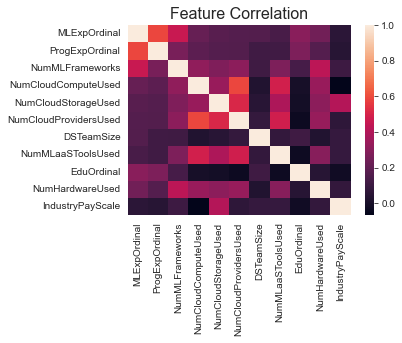

In [47]:
plt.figure(figsize=(5,3.5))
sns.heatmap(df_merged[num_feats].corr())
plt.title("Feature Correlation", size=16)
plt.show()

# Modeling 

### Train Test Split

In [48]:
X_train, X_test, y_train, y_test = train_test_split(
                                df_merged.drop(['PID', 'salary'], axis=1), df_merged['salary'], 
                                test_size=0.20, random_state=seed)

In [49]:
X_train.shape, X_test.shape

((1890, 67), (473, 67))

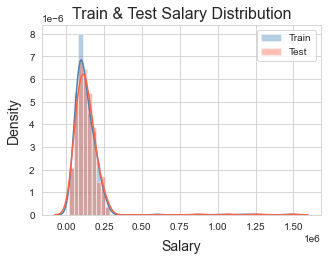

In [50]:
plt.figure(figsize=(5,3.5))
sns.distplot(y_train, color='steelblue', label="Train")
sns.distplot(y_test, color='tomato', label="Test")
plt.title("Train & Test Salary Distribution", size=16)
plt.xlabel("Salary", fontsize=14, labelpad=8)
plt.ylabel("Density", fontsize=14, labelpad=8)
plt.legend()
plt.show()

In [51]:
def get_regression_metrics(model, X, y_true, label):
    y_pred = model.predict(X)
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    maxerror = max_error(y_true, y_pred)
    
    metrics = pd.DataFrame({"R2":round(r2,3), "RMSE":round(rmse,3), "MAE":round(mae,3),
                            "MAPE":round(mape,3), "Max Error":round(maxerror,3)},
                           index=[f"{label}"]).T
    return metrics

In [52]:
def get_train_test_metrics(model, X_train, y_train, X_test, y_test, label_tr="Train", label_te="Test"):
    train_metrics = get_regression_metrics(model, X_train, y_train, label_tr)
    test_metrics = get_regression_metrics(model, X_test, y_test, label_te)
    return train_metrics.join(test_metrics)

In [53]:
def get_adj_train_test(uppercap, X_train, y_train, X_test, y_test):
    y_train_adj = y_train[y_train <= uppercap]
    X_train_adj = X_train.loc[y_train_adj.index]
    
    y_test_adj = y_test[y_test <= uppercap]
    X_test_adj = X_test.loc[y_test_adj.index]

    return X_train_adj, y_train_adj, X_test_adj, y_test_adj

In [54]:
def plot_true_pred(model, X_train, y_train, X_test, y_test):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    fig, axs = plt.subplots(1,2, figsize=(11,3), gridspec_kw={"wspace":0.3}, sharey=True)
    axs[0].scatter(y_train, y_pred_train, marker='o', s=2, alpha=0.5, color='lightsalmon')
    axs[1].scatter(y_test, y_pred_test, marker='o', s=2, alpha=0.5, color='lightsalmon')

    x = np.linspace(0, 7e5)
    y = np.linspace(0, 7e5)
    for i in range(2):
        axs[i].plot(x, y, color='darkred', label='Ideal Fit')
        axs[i].set_xlabel("Actual y", fontsize=14, labelpad=8)
        axs[i].set_ylabel("Predicted y", fontsize=14, labelpad=8)
    axs[0].set_title("Train", size=18, pad=8)
    axs[1].set_title("Test", size=18, pad=8)
    axs[0].set_xlim(0, 500000)
    axs[0].set_ylim(0, 500000)
    axs[1].set_xlim(0, 500000)
    axs[1].set_ylim(0, 500000)
    plt.legend()
    plt.show()

In [55]:
def plot_residuals(model, X_train, y_train, X_test, y_test, multiply=1):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    fig, axs = plt.subplots(1,2, figsize=(11,3), gridspec_kw={"wspace":0.3}, sharey=True)
    axs[0].scatter(y_train, multiply*(y_pred_train-y_train), marker='o', s=2, alpha=0.9, color='wheat')
    axs[1].scatter(y_test, multiply*(y_pred_test-y_test), marker='o', s=2, alpha=0.9, color='wheat')

    x = np.linspace(0, 7e5)
    y = np.linspace(0, 7e5)
    for i in range(2):
        axs[i].axhline(y=0, color='darkred', label='Ideal Fit')
        axs[i].set_xlabel("Actual y", fontsize=14, labelpad=8)
        axs[i].set_ylabel("Residuals", fontsize=14, labelpad=8)
    axs[0].set_title("Train", size=18, pad=8)
    axs[1].set_title("Test", size=18, pad=8)
    axs[0].set_xlim(0, 500000)
    axs[0].set_ylim(-250000, 250000)
    axs[1].set_xlim(0, 500000)
    axs[1].set_ylim(-250000, 250000)
    plt.legend()
    plt.show()

In [56]:
def plot_with_err(x, data, **kwargs):
    # Plots the scoring metric wrt varying hyperparameter. Highlights within 1 SD.
    mu, std = data.mean(1), data.std(1) # Mean and std across cols
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2) # Function for plotting between two horizontal lines y1=mu-std and y2=mu+std

In [57]:
def plot_learning_curve(model, model_name, X_train, y_train, metric="r2"):
    train_sizes = np.linspace(0.05, 1, 20)
    N_train, val_train, val_test = learning_curve(model, X_train, y_train, scoring=metric, n_jobs=64,
                                                 random_state=seed)
    plot_with_err(N_train, val_train, label='Train scores')
    plot_with_err(N_train, val_test, label='Validation scores')
    plt.title(f"Learning Curves ({model_name})", size=18, pad=8)
    plt.xlabel(r"Train set size", fontsize=16, labelpad=8)
    plt.ylabel('$R^2$', fontsize=16, labelpad=8)
    plt.legend()
    plt.show()

# ML Modeling

In [58]:
X_train_linear = X_train.drop(ENCODED_CATEG_FEATURES, axis=1)[final_feats]
X_test_linear = X_test.drop(ENCODED_CATEG_FEATURES, axis=1)[final_feats]

In [59]:
# Adjusted Dataset
uppercap = 500000 # Remove salaries greater than this value
X_train_adj, y_train_adj, X_test_adj, y_test_adj = get_adj_train_test(uppercap, 
                                                            X_train_linear, y_train, X_test_linear, y_test)

### OLS Regression <a name="ols"></a>

                 Train         Test   Adj Train    Adj Test
R2               0.159        0.180       0.389       0.393
RMSE        102025.672   101659.621   42936.544   42440.671
MAE          44854.486    43659.297   33288.016   32452.855
MAPE             0.399        0.371       0.346       0.324
Max Error  1359446.236  1188356.252  164069.855  142990.083


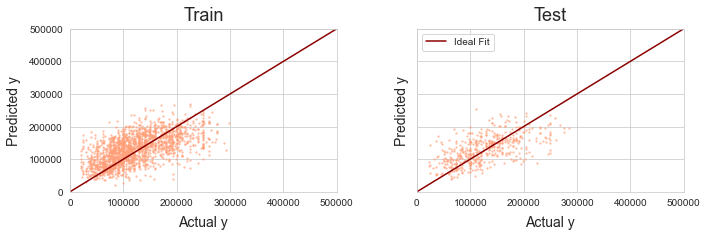

In [60]:
lr_model = LinearRegression()
lr_model.fit(X_train_linear, y_train)
metrics = get_train_test_metrics(lr_model, X_train_linear, y_train, X_test_linear, y_test)

lr_model_adj = LinearRegression()
lr_model_adj.fit(X_train_adj, y_train_adj)
adj_metrics = get_train_test_metrics(lr_model_adj, X_train_adj, y_train_adj, X_test_adj, y_test_adj, 
                                     "Adj Train", "Adj Test")
lr_metrics = metrics.join(adj_metrics)
print(lr_metrics)
plot_true_pred(lr_model, X_train_linear, y_train, X_test_linear, y_test)

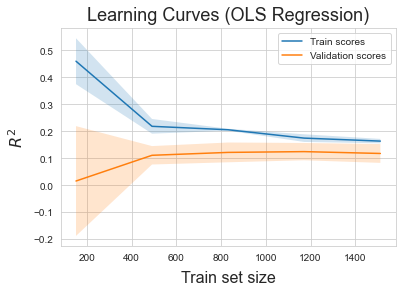

In [61]:
plot_learning_curve(lr_model, "OLS Regression", X_train_linear, y_train, "r2")

In [62]:
# Underfitting, so regularization not reqd!

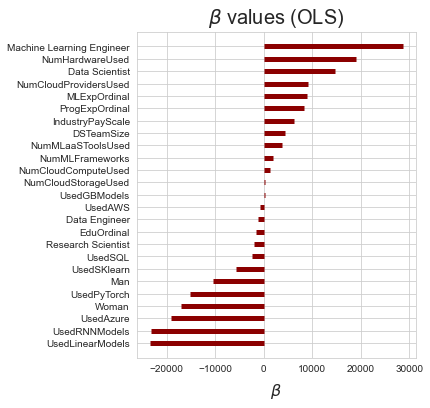

In [63]:
betas = pd.DataFrame(lr_model.coef_, index=X_train_linear.columns, columns=["Beta"])
betas = betas.sort_values(by="Beta")

plt.figure(figsize=(5,6))
plt.hlines(betas.index, xmin=0, xmax=betas['Beta'], linewidth=5, color='darkred')

plt.title(r"$\beta$ values (OLS)", size=20, pad=8)
plt.xlabel(r"$\beta$", fontsize=16, labelpad=8)
plt.show()

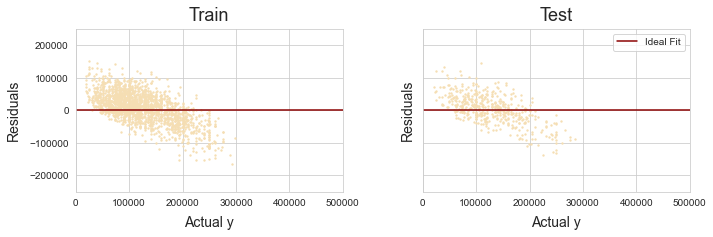

In [64]:
plot_residuals(lr_model, X_train_linear, y_train, X_test_linear, y_test)

### Ridge Regression <a name="ridge"></a>

(with Grid Search & Stratified k-fold CV)

In [65]:
#sorted(sklearn.metrics.SCORERS.keys())

In [66]:
params = {"alpha": [0, 0.1, 1, 10, 50, 100, 200, 250, 500]}
ridge_grid = GridSearchCV(Ridge(), params, scoring="r2", cv=5)

(Ridge) Ideal Regularization constant = 250
(Ridge) Ideal Regularization constant (Adjusted Data) = 10

                 Train         Test   Adj Train    Adj Test
R2               0.151        0.186       0.388       0.393
RMSE        102521.840   101317.698   42944.219   42440.210
MAE          44011.925    41876.663   33310.749   32443.283
MAPE             0.395        0.358       0.346       0.323
Max Error  1367851.779  1214754.456  164553.870  141881.174


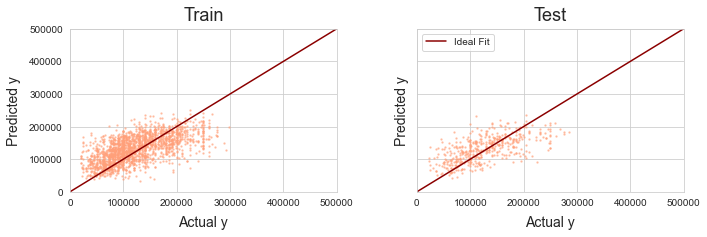

In [67]:
# Full dataset
ridge_grid = GridSearchCV(Ridge(), params, scoring="r2", cv=5) # 5-fold CV
ridge_grid.fit(X_train_linear, y_train)
print(f"(Ridge) Ideal Regularization constant = {ridge_grid.best_params_['alpha']}")
    
# Fit best param model on train
ridge = Ridge(**ridge_grid.best_params_)
ridge.fit(X_train_linear, y_train)
metrics = get_train_test_metrics(ridge, X_train_linear, y_train, X_test_linear, y_test)

# ------------------------------------------------------------------------------------------

# Adjusted Dataset
ridge_grid_adj = GridSearchCV(Ridge(), params, scoring="r2", cv=5) # 5-fold CV
ridge_grid_adj.fit(X_train_adj, y_train_adj)
print(f"(Ridge) Ideal Regularization constant (Adjusted Data) = {ridge_grid_adj.best_params_['alpha']}\n")

# Fit best param model on train
ridge_adj = Ridge(**ridge_grid_adj.best_params_)
ridge_adj.fit(X_train_adj, y_train_adj)
adj_metrics = get_train_test_metrics(ridge_adj, X_train_adj, y_train_adj, X_test_adj, y_test_adj, 
                                     "Adj Train", "Adj Test")

# Results
ridge_metrics = metrics.join(adj_metrics)
print(ridge_metrics)
plot_true_pred(ridge, X_train_linear, y_train, X_test_linear, y_test)

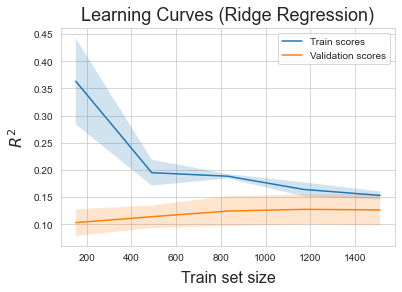

In [147]:
plot_learning_curve(ridge, "Ridge Regression", X_train_linear, y_train, "r2")

In [62]:
# Underfitting, so regularization not reqd!

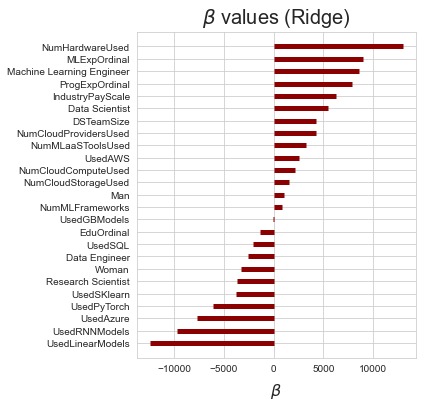

In [148]:
betas = pd.DataFrame(ridge.coef_, index=X_train_linear.columns, columns=["Beta"])
betas = betas.sort_values(by="Beta")

plt.figure(figsize=(5,6))
plt.hlines(betas.index, xmin=0, xmax=betas['Beta'], linewidth=5, color='darkred')

plt.title(r"$\beta$ values (Ridge)", size=20, pad=8)
plt.xlabel(r"$\beta$", fontsize=16, labelpad=8)
plt.show()

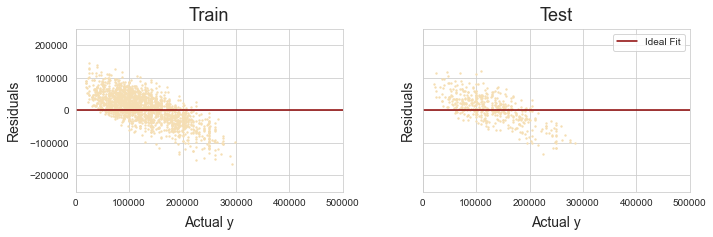

In [149]:
plot_residuals(ridge, X_train_linear, y_train, X_test_linear, y_test)

### Lasso Regression <a name="lasso"></a>

In [68]:
params = {"alpha": [0, 0.1, 1, 10, 50, 100, 200, 250, 500]}

(Lasso) Ideal Regularization constant = 500
(Lasso) Ideal Regularization constant (Adjusted Data) = 250

                 Train         Test   Adj Train    Adj Test
R2               0.157        0.184       0.386       0.392
RMSE        102154.428   101418.478   43032.356   42503.664
MAE          44299.037    42627.604   33450.254   32462.521
MAPE             0.395        0.362       0.348       0.324
Max Error  1360576.125  1201776.244  165798.932  138941.223


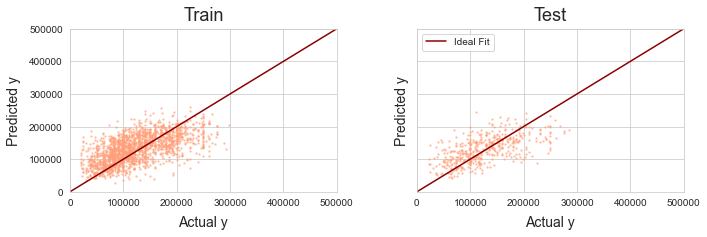

In [69]:
# Full dataset
lasso_grid = GridSearchCV(Lasso(), params, scoring="r2", cv=5) # 5-fold CV
lasso_grid.fit(X_train_linear, y_train)
print(f"(Lasso) Ideal Regularization constant = {lasso_grid.best_params_['alpha']}")
    
# Fit best param model on train
lasso = Lasso(**lasso_grid.best_params_)
lasso.fit(X_train_linear, y_train)
metrics = get_train_test_metrics(lasso, X_train_linear, y_train, X_test_linear, y_test)

# ------------------------------------------------------------------------------------------

# Adjusted Dataset
lasso_grid_adj = GridSearchCV(Lasso(), params, scoring="r2", cv=5) # 5-fold CV
lasso_grid_adj.fit(X_train_adj, y_train_adj)
print(f"(Lasso) Ideal Regularization constant (Adjusted Data) = {lasso_grid_adj.best_params_['alpha']}\n")

# Fit best param model on train
lasso_adj = Lasso(**lasso_grid_adj.best_params_)
lasso_adj.fit(X_train_adj, y_train_adj)
adj_metrics = get_train_test_metrics(lasso_adj, X_train_adj, y_train_adj, X_test_adj, y_test_adj, 
                                     "Adj Train", "Adj Test")

# Results
lasso_metrics = metrics.join(adj_metrics)
print(lasso_metrics)
plot_true_pred(lasso, X_train_linear, y_train, X_test_linear, y_test)

In [70]:
# Features dropped by Lasso
lz = np.array(lasso.coef_)
X_train_linear.columns[np.argwhere(lz==0).reshape(-1)]

Index(['UsedAWS', 'UsedSQL', 'UsedGBModels', 'Man', 'Data Engineer',
       'Research Scientist'],
      dtype='object')

### Support Vector Regression (Linear) <a name="svr"></a>

In [71]:
params = {"C": [0, 0.01, 0.1, 1, 10]}

(linsvr) Ideal Regularization constant = 10
(linsvr) Ideal Regularization constant (Adjusted Data) = 10

                 Train         Test   Adj Train    Adj Test
R2               0.092        0.113       0.306       0.298
RMSE        106025.633   105768.256   45738.159   45659.152
MAE          43547.750    42765.661   34997.341   34656.692
MAPE             0.342        0.324       0.335       0.318
Max Error  1417175.355  1310324.858  189184.930  145558.777


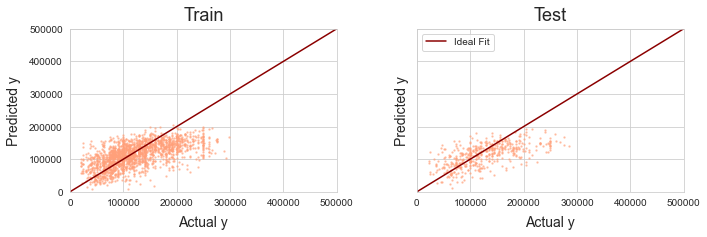

In [72]:
# Full dataset
linsvr_grid = GridSearchCV(LinearSVR(), params, scoring="r2", cv=5) # 5-fold CV
linsvr_grid.fit(X_train_linear, y_train)
print(f"(linsvr) Ideal Regularization constant = {linsvr_grid.best_params_['C']}")
    
# Fit best param model on train
linsvr = LinearSVR(**linsvr_grid.best_params_)
linsvr.fit(X_train_linear, y_train)
metrics = get_train_test_metrics(linsvr, X_train_linear, y_train, X_test_linear, y_test)

# ------------------------------------------------------------------------------------------

# Adjusted Dataset
linsvr_grid_adj = GridSearchCV(LinearSVR(), params, scoring="r2", cv=5) # 5-fold CV
linsvr_grid_adj.fit(X_train_adj, y_train_adj)
print(f"(linsvr) Ideal Regularization constant (Adjusted Data) = {linsvr_grid_adj.best_params_['C']}\n")

# Fit best param model on train
linsvr_adj = LinearSVR(**linsvr_grid_adj.best_params_)
linsvr_adj.fit(X_train_adj, y_train_adj)
adj_metrics = get_train_test_metrics(linsvr_adj, X_train_adj, y_train_adj, X_test_adj, y_test_adj, 
                                     "Adj Train", "Adj Test")

# Results
linsvr_metrics = metrics.join(adj_metrics)
print(linsvr_metrics)
plot_true_pred(linsvr, X_train_linear, y_train, X_test_linear, y_test)

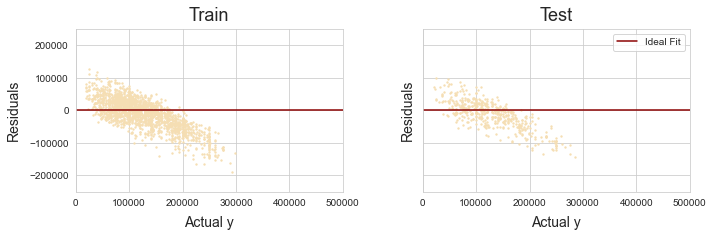

In [73]:
plot_residuals(linsvr, X_train_linear, y_train, X_test_linear, y_test)

### Support Vector Regression (Non-linear)

In [74]:
params = {"C": [0, 0.001, 0.01]}

(svr) Ideal Regularization constant = 0.01
(svr) Ideal Regularization constant (Adjusted Data) = 0.01

                 Train         Test   Adj Train    Adj Test
R2              -0.026       -0.035      -0.035      -0.064
RMSE        112681.328   114248.473   55863.030   56217.286
MAE          53037.352    52694.601   44247.241   44232.553
MAPE             0.464        0.437       0.454       0.428
Max Error  1378892.908  1383391.685  184121.712  170945.786


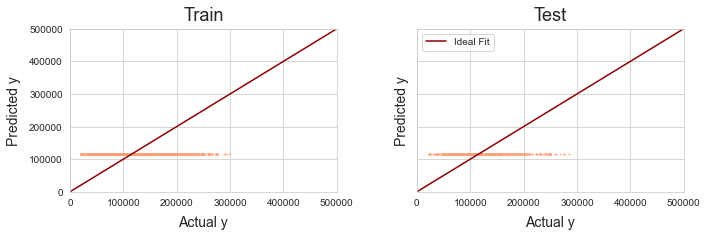

In [75]:
# Full dataset
svr_grid = GridSearchCV(SVR(), params, scoring="r2", cv=5) # 5-fold CV
svr_grid.fit(X_train_linear, y_train)
print(f"(svr) Ideal Regularization constant = {svr_grid.best_params_['C']}")
    
# Fit best param model on train
svr = SVR(**svr_grid.best_params_)
svr.fit(X_train_linear, y_train)
metrics = get_train_test_metrics(svr, X_train_linear, y_train, X_test_linear, y_test)

# ------------------------------------------------------------------------------------------

# Adjusted Dataset
svr_grid_adj = GridSearchCV(SVR(), params, scoring="r2", cv=5) # 5-fold CV
svr_grid_adj.fit(X_train_adj, y_train_adj)
print(f"(svr) Ideal Regularization constant (Adjusted Data) = {svr_grid_adj.best_params_['C']}\n")

# Fit best param model on train
svr_adj = SVR(**svr_grid_adj.best_params_)
svr_adj.fit(X_train_adj, y_train_adj)
adj_metrics = get_train_test_metrics(svr_adj, X_train_adj, y_train_adj, X_test_adj, y_test_adj, 
                                     "Adj Train", "Adj Test")

# Results
svr_metrics = metrics.join(adj_metrics)
print(svr_metrics)
plot_true_pred(svr, X_train_linear, y_train, X_test_linear, y_test)

### Random Forest Regression <a name="rf"></a>

In [76]:
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 300, num = 10)] # No. Trees
max_depth = [int(x) for x in np.linspace(5, 15, num = 6)] # Tree Depth
max_depth.append(None)
min_samples_split = [2, 5, 10] # Min samples to split a node (Def 2)
min_samples_leaf = [1, 2, 4] # Min samples at leaf node (Def 1)
max_features = ['auto', 'sqrt'] # No. features at split

rf_params = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
                'max_features': max_features,
            }
rf_params

{'n_estimators': [50, 77, 105, 133, 161, 188, 216, 244, 272, 300],
 'max_depth': [5, 7, 9, 11, 13, 15, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'max_features': ['auto', 'sqrt']}

                Train         Test   Adj Train    Adj Test
R2              0.863        0.165       0.674       0.399
RMSE        41233.488   102618.475   31363.539   42226.872
MAE         20851.551    43159.201   24377.298   32174.541
MAPE            0.197        0.378       0.258       0.321
Max Error  577059.597  1203043.747  117892.264  137497.289


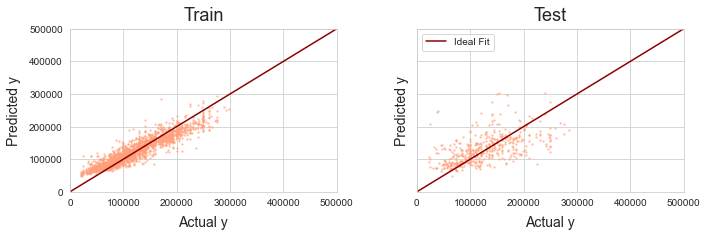

In [77]:
# Full dataset
rf_grid = RandomizedSearchCV(RandomForestRegressor(), rf_params, scoring="r2", n_iter=50,
                             cv=5, n_jobs=64) # 5-fold CV  neg_mean_squared_error
rf_grid.fit(X_train_linear, y_train)
    
# Fit best param model on train
rf = RandomForestRegressor(**rf_grid.best_params_)
rf.fit(X_train_linear, y_train)
metrics = get_train_test_metrics(rf, X_train_linear, y_train, X_test_linear, y_test)

# ------------------------------------------------------------------------------------------

# Adjusted Dataset
rf_grid_adj = RandomizedSearchCV(RandomForestRegressor(), rf_params, scoring="r2", n_iter=50,
                           cv=5, n_jobs=64) # 5-fold CV
rf_grid_adj.fit(X_train_adj, y_train_adj)

# Fit best param model on train
rf_adj = RandomForestRegressor(**rf_grid_adj.best_params_)
rf_adj.fit(X_train_adj, y_train_adj)
adj_metrics = get_train_test_metrics(rf_adj, X_train_adj, y_train_adj, X_test_adj, y_test_adj, 
                                     "Adj Train", "Adj Test")

# Results
rf_metrics = metrics.join(adj_metrics)
print(rf_metrics)
plot_true_pred(rf, X_train_linear, y_train, X_test_linear, y_test)

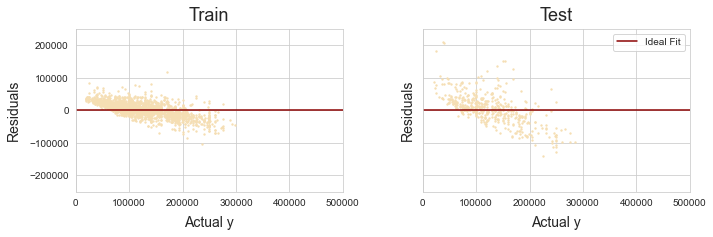

In [78]:
plot_residuals(rf, X_train_linear, y_train, X_test_linear, y_test)

In [79]:
rf_grid.best_params_

{'n_estimators': 216,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 13}

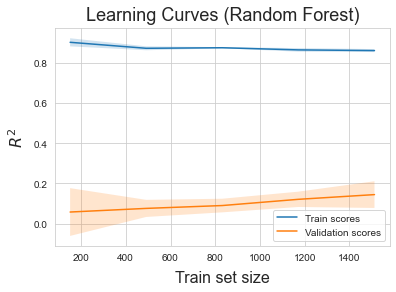

In [80]:
plot_learning_curve(rf, "Random Forest", X_train_linear, y_train, "r2") # Overfitting!

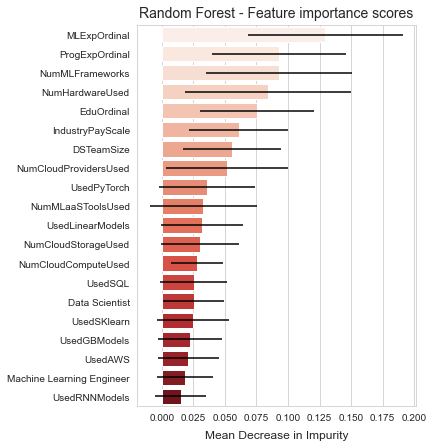

In [81]:
# Feature Importances
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=X_test_linear.columns)
order = np.argsort(forest_importances.values)[::-1] # Reordering scores
forest_importances = forest_importances.iloc[order][:20]
std = std[order][:20]

plt.figure(figsize=(5,7))
sns.barplot(forest_importances.values, forest_importances.index, xerr=std, palette="Reds")
plt.title("Random Forest - Feature importance scores", size=14, pad=8)
plt.xlabel("Mean Decrease in Impurity", fontsize=12, labelpad=8)
# plt.ylabel("", fontsize=14, labelpad=8)
plt.show()

### XGBoost Regression <a name="xgb"></a>

In [82]:
xgb_params = {'n_estimators': stats.randint(150, 1000),
              'learning_rate': stats.uniform(0.01, 0.59),
              'subsample': stats.uniform(0.3, 0.6),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.4),
              'min_child_weight': [1, 2, 3, 4]
             }

                 Train         Test   Adj Train    Adj Test
R2               0.433        0.178       0.516       0.404
RMSE         83810.860   101807.493   38195.512   42071.509
MAE          40052.805    43514.227   29458.345   31697.841
MAPE             0.359        0.369       0.306       0.313
Max Error  1160067.232  1153535.090  151167.519  136478.281


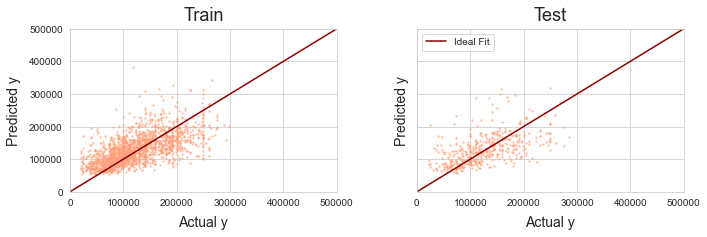

In [83]:
# Full dataset
xgb_grid = RandomizedSearchCV(XGBRegressor(), xgb_params, scoring="r2", n_iter=50,
                             cv=5, n_jobs=64) # 5-fold CV
xgb_grid.fit(X_train_linear, y_train)
    
# Fit best param model on train
xgb = XGBRegressor(**xgb_grid.best_params_)
xgb.fit(X_train_linear, y_train)
metrics = get_train_test_metrics(xgb, X_train_linear, y_train, X_test_linear, y_test)

# ------------------------------------------------------------------------------------------

# Adjusted Dataset
xgb_grid_adj = RandomizedSearchCV(XGBRegressor(), xgb_params, scoring="r2", n_iter=50,
                           cv=5, n_jobs=64) # 5-fold CV
xgb_grid_adj.fit(X_train_adj, y_train_adj)

# Fit best param model on train
xgb_adj = XGBRegressor(**xgb_grid_adj.best_params_)
xgb_adj.fit(X_train_adj, y_train_adj)
adj_metrics = get_train_test_metrics(xgb_adj, X_train_adj, y_train_adj, X_test_adj, y_test_adj, 
                                     "Adj Train", "Adj Test")

# Results
xgb_metrics = metrics.join(adj_metrics)
print(xgb_metrics)
plot_true_pred(xgb, X_train_linear, y_train, X_test_linear, y_test)

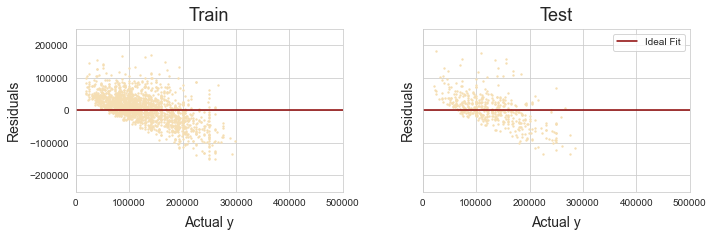

In [84]:
plot_residuals(xgb, X_train_linear, y_train, X_test_linear, y_test)

In [85]:
xgb_grid.best_params_

{'colsample_bytree': 0.5506974826304447,
 'learning_rate': 0.04152851122343148,
 'max_depth': 4,
 'min_child_weight': 2,
 'n_estimators': 154,
 'subsample': 0.4457876183789521}

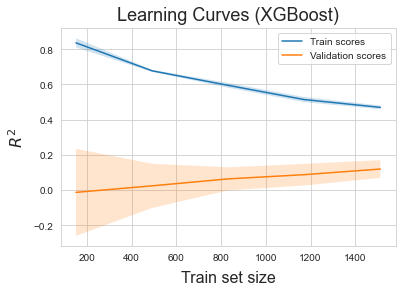

In [86]:
plot_learning_curve(xgb, "XGBoost", X_train_linear, y_train, "r2") # Overfitting

In [183]:
xgb_imps = pd.DataFrame({'feature':X_train_linear.columns, 'imp':xgb.feature_importances_})
xgb_imps = xgb_imps.sort_values('imp', ascending=False)

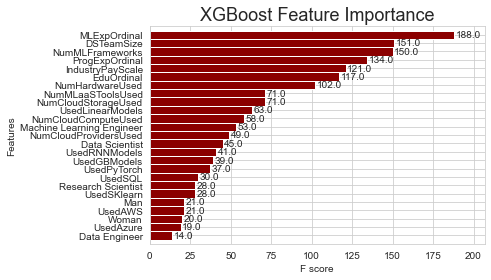

In [184]:
plot_importance(xgb, height=1, max_num_features=100, color="darkred")
plt.title("XGBoost Feature Importance", size=18)
plt.show()

## CV scores comparison <a name="comparison"></a>

In [113]:
def aggregate_metrics():
    lr_df = lr_metrics.reset_index()
    ridge_df = ridge_metrics.reset_index()
    lasso_df = lasso_metrics.reset_index()
    linsvr_df = linsvr_metrics.reset_index()
    rf_df = rf_metrics.reset_index()
    xgb_df = xgb_metrics.reset_index()
    lr_df['Model'] = 'OLS'
    ridge_df['Model'] = 'Ridge'
    lasso_df['Model'] = 'Lasso'
    linsvr_df['Model'] = 'Linear SVR'
    rf_df['Model'] = 'Random Forest'
    xgb_df['Model'] = 'XGBoost'
    agg_metrics = pd.concat([lr_df, ridge_df, lasso_df, linsvr_df, rf_df, xgb_df], axis=0, ignore_index=True)
    agg_metrics = agg_metrics.rename(columns={'index':'Metric'})
    cols = ['Model', 'Metric'] + lr_df.columns.tolist()[1:]
    agg_metrics = agg_metrics[cols]
    return agg_metrics

In [114]:
agg_metrics = aggregate_metrics()
agg_metrics[agg_metrics['Metric'] == 'R2']

,Model,Metric,Train,Test,Adj Train,Adj Test,Model
0,OLS,R2,0.159,0.180,0.389,0.393,OLS
5,Ridge,R2,0.151,0.186,0.388,0.393,Ridge
10,Lasso,R2,0.157,0.184,0.386,0.392,Lasso
15,Linear SVR,R2,0.092,0.113,0.306,0.298,Linear SVR
20,Random Forest,R2,0.863,0.165,0.674,0.399,Random Forest
25,XGBoost,R2,0.433,0.178,0.516,0.404,XGBoost


In [144]:
def get_scores(model, model_name):
    scores = cross_val_score(model, X_train_linear, y_train, scoring="r2", cv=5)
    score_df = pd.DataFrame(scores, columns=['R2'])
    score_df['Model'] = model_name
    return score_df

In [145]:
lr_scores = get_scores(lr_model, 'OLS')
ridge_scores = get_scores(ridge, 'Ridge')
lasso_scores = get_scores(lasso, 'Lasso')
linsvr_scores = get_scores(linsvr, 'Linear SVR')
rf_scores = get_scores(rf, 'Random Forest')
xgb_scores = get_scores(xgb, 'XGBoost')
all_scores = pd.concat([lr_scores, ridge_scores, lasso_scores, linsvr_scores,
                        rf_scores, xgb_scores], axis=0, ignore_index=True)

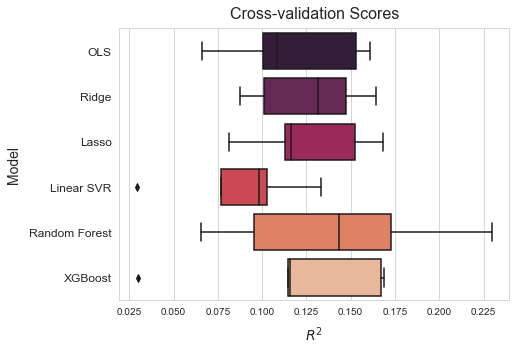

In [146]:
plt.figure(figsize=(7,5))
sns.boxplot(y='Model', x='R2', data=all_scores, palette='rocket')
plt.title("Cross-validation Scores", size=16, pad=10)
plt.yticks(size=12)
plt.ylabel("Model", fontsize=14, labelpad=8)
plt.xlabel('$R^2$', fontsize=14, labelpad=8)
plt.show()

# Generalized Linear Models <a name="glm"></a>

In [92]:
nb_train = X_train_linear.copy()
nb_train['salary'] = y_train
nb_test = X_test_linear.copy()
nb_test['salary'] = y_test

nb_train = nb_train.rename(columns={t: "".join(t.split()) for t in nb_train.columns[-5:-1].tolist()})
nb_test = nb_test.rename(columns={t: "".join(t.split()) for t in nb_test.columns[-5:-1].tolist()})

In [93]:
# Regression Equation
expr = "salary ~ " + "+".join(nb_train.columns[:-1])

y_train_nb, X_train_nb = dmatrices(expr, nb_train, return_type='dataframe')
y_test_nb, X_test_nb = dmatrices(expr, nb_test, return_type='dataframe')

In [94]:
poisson_model = sm.GLM(y_train_nb, X_train_nb, family=sm.families.Poisson()).fit()
nb_model = sm.GLM(y_train_nb, X_train_nb, family=sm.families.NegativeBinomial()).fit()
gamma_model = sm.GLM(y_train_nb, X_train_nb, family=sm.families.Gamma()).fit()

In [95]:
nb_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 salary   No. Observations:                 1890
Model:                            GLM   Df Residuals:                     1864
Model Family:        NegativeBinomial   Df Model:                           25
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -24084.
Date:                Mon, 19 Dec 2022   Deviance:                       396.78
Time:                        20:09:40   Pearson chi2:                     885.
No. Iterations:                    15   Pseudo R-squ. (CS):             0.1013
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  11.0635      0.184     60.073      0.000      10.703      11.424
MLExpOrdinal                0.0564      0.015      3.686      0.000       0.026       0.086
ProgExpOrdinal              0.0695      0.017      4.104      0.000       0.036       0.103
NumMLFrameworks             0.0051      0.018      0.281      0.779      -0.031       0.041
NumCloudComputeUsed         0.0200      0.032      0.627      0.531      -0.043       0.083
NumCloudStorageUsed        -0.0271      0.035     -0.773      0.440      -0.096       0.042
NumCloudProvidersUsed       0.0300      0.044      0.676      0.499      -0.057       0.117
DSTeamSize                  0.0275      0.011      2.437      0.015       0.005       0.050
NumMLaaSToolsUsed           0.0224      0.035      0.633      0.527      -0.047       0.092
EduOrdinal                 -0.0015      0.032     -0.047      0.962      -0.063       0.060
NumHardwareUsed             0.1349      0.045      2.978      0.003       0.046       0.224
IndustryPayScale            0.0521      0.016      3.243      0.001       0.021       0.084
UsedAWS                     0.0334      0.070      0.477      0.634      -0.104       0.171
UsedSQL                    -0.0122      0.055     -0.221      0.825      -0.120       0.096
UsedGBModels                0.0271      0.059      0.462      0.644      -0.088       0.142
UsedSKlearn                -0.0261      0.064     -0.405      0.685      -0.152       0.100
UsedPyTorch                -0.0694      0.063     -1.099      0.272      -0.193       0.054
UsedRNNModels              -0.1466      0.067     -2.183      0.029      -0.278      -0.015
UsedAzure                  -0.0580      0.074     -0.783      0.434      -0.203       0.087
UsedLinearModels           -0.1375      0.062     -2.217      0.027      -0.259      -0.016
Man                        -0.0610      0.153     -0.399      0.690      -0.360       0.238
Woman                      -0.1047      0.160     -0.655      0.513      -0.418       0.209
DataEngineer                0.0434      0.102      0.426      0.670      -0.156       0.243
DataScientist               0.1533      0.068      2.243      0.025       0.019       0.287
MachineLearningEngineer     0.2156      0.100      2.147      0.032       0.019       0.412
ResearchScientist           0.0120      0.088      0.136      0.892      -0.161       0.185
===========================================================================================
"""

In [96]:
poisson_preds_tr = poisson_model.get_prediction(X_train_nb)
poisson_preds_tr = poisson_preds_tr.summary_frame()
# print(poisson_preds_tr)
r2_score(y_train_nb, poisson_preds_tr["mean"])

0.18159988008994643

In [97]:
poisson_preds_te = poisson_model.get_prediction(X_test_nb)
poisson_preds_te = poisson_preds_te.summary_frame()
# print(poisson_preds_te)
r2_score(y_test_nb, poisson_preds_te["mean"])

0.22328572843833994

In [98]:
nb_preds_tr = nb_model.get_prediction(X_train_nb)
nb_preds_tr = nb_preds_tr.summary_frame()
# print(nb_preds_tr)
r2_score(y_train_nb, nb_preds_tr["mean"])

0.17124200140478074

In [99]:
nb_preds_te = nb_model.get_prediction(X_test_nb)
nb_preds_te = nb_preds_te.summary_frame()
# print(nb_preds_te)
r2_score(y_test_nb, nb_preds_te["mean"])

0.21193808883800036

In [100]:
gamma_preds_tr = gamma_model.get_prediction(X_train_nb)
gamma_preds_tr = gamma_preds_tr.summary_frame()
# print(gamma_preds_tr)
r2_score(y_train_nb, gamma_preds_tr["mean"])

-0.6160390229278649

In [101]:
gamma_preds_te = gamma_model.get_prediction(X_test_nb)
gamma_preds_te = gamma_preds_te.summary_frame()
# print(gamma_preds_te)
r2_score(y_test_nb, gamma_preds_te["mean"])

-0.7033273424628139

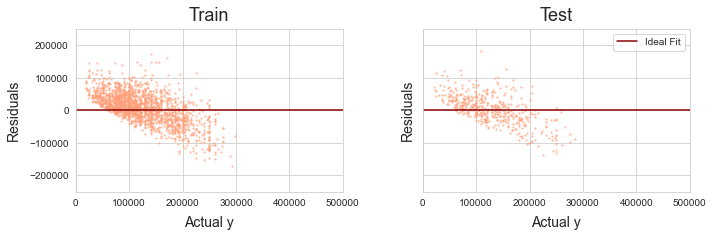

In [102]:
fig, axs = plt.subplots(1,2, figsize=(11,3), gridspec_kw={"wspace":0.3}, sharey=True)
axs[0].scatter(y_train_nb, pd.DataFrame(poisson_preds_tr["mean"]).rename(columns={"mean":"salary"})-y_train_nb, marker='o', s=2, alpha=0.5, color='lightsalmon')
axs[1].scatter(y_test_nb, pd.DataFrame(poisson_preds_te["mean"]).rename(columns={"mean":"salary"})-y_test_nb, marker='o', s=2, alpha=0.5, color='lightsalmon')

x = np.linspace(0, 7e5)
y = np.linspace(0, 7e5)
for i in range(2):
    axs[i].axhline(y=0, color='darkred', label='Ideal Fit')
    axs[i].set_xlabel("Actual y", fontsize=14, labelpad=8)
    axs[i].set_ylabel("Residuals", fontsize=14, labelpad=8)
axs[0].set_title("Train", size=18, pad=8)
axs[1].set_title("Test", size=18, pad=8)
axs[0].set_xlim(0, 500000)
axs[0].set_ylim(-250000, 250000)
axs[1].set_xlim(0, 500000)
axs[1].set_ylim(-250000, 250000)
plt.legend()
plt.show()

### Adjusted Dataset

In [103]:
uppercap = 500000
nb_train = nb_train[nb_train['salary'] <= uppercap]
nb_test = nb_test[nb_test['salary'] <= uppercap]
y_train_nb, X_train_nb = dmatrices(expr, nb_train, return_type='dataframe')
y_test_nb, X_test_nb = dmatrices(expr, nb_test, return_type='dataframe')
X_train_nb.shape

(1872, 26)

In [104]:
poisson_model = sm.GLM(y_train_nb, X_train_nb, family=sm.families.Poisson()).fit()
nb_model = sm.GLM(y_train_nb, X_train_nb, family=sm.families.NegativeBinomial()).fit()
gamma_model = sm.GLM(y_train_nb, X_train_nb, family=sm.families.Gamma()).fit()

In [105]:
poisson_preds_tr = poisson_model.get_prediction(X_train_nb)
poisson_preds_tr = poisson_preds_tr.summary_frame()
r2_score(y_train_nb, poisson_preds_tr["mean"])

0.3962555041672752

In [106]:
poisson_preds_te = poisson_model.get_prediction(X_test_nb)
poisson_preds_te = poisson_preds_te.summary_frame()
r2_score(y_test_nb, poisson_preds_te["mean"])

0.40104920869290117

In [107]:
nb_preds_tr = nb_model.get_prediction(X_train_nb)
nb_preds_tr = nb_preds_tr.summary_frame()
r2_score(y_train_nb, nb_preds_tr["mean"])

0.3939153313046797

In [108]:
nb_preds_te = nb_model.get_prediction(X_test_nb)
nb_preds_te = nb_preds_te.summary_frame()
r2_score(y_test_nb, nb_preds_te["mean"])

0.3980478023983838

In [109]:
gamma_preds_tr = gamma_model.get_prediction(X_train_nb)
gamma_preds_tr = gamma_preds_tr.summary_frame()
r2_score(y_train_nb, gamma_preds_tr["mean"])

0.37780353203407124

In [110]:
gamma_preds_te = gamma_model.get_prediction(X_test_nb)
gamma_preds_te = gamma_preds_te.summary_frame()
r2_score(y_test_nb, gamma_preds_te["mean"])

0.3875694392147543